# Introduction

A health insurance company can only make money if it collects more than what it spends on the medical care of its beneficiaries. On the other hand, even though some conditions are more prevalent for certain segments of the population, medical costs are difficult to predict since most money comes from rare conditions of the patients. The aim of this project is to first analyze the factors that influence medical costs by explorating the dataset and all the components in order to discover correlations between datas, and secondly try to build an adequate model that can accurately predict insurance costs bsed on the data and optimize its performance.

In [1]:
#LIBRARIES
library(dplyr)
library("caret")
library("car")
library("tidyverse")
library("patchwork")
library("ggforce")
library(factoextra)
library(ggplot2)
library(corrplot)
library(ggExtra)
library("Metrics")
library("GGally")


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


Loading required package: lattice

Loading required package: ggplot2


Attaching package: ‘caret’


The following object is masked from ‘package:httr’:

    progress


Loading required package: carData


Attaching package: ‘car’


The following object is masked from ‘package:dplyr’:

    recode


── Attaching packages ─────────────────────────────────────── tidyverse 1.3.0 ──

✔ tibble  3.0.0     ✔ purrr   0.3.4
✔ tidyr   1.0.2     ✔ stringr 1.4.0
✔ readr   1.3.1     ✔ forcats 0.5.0

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter()   masks stats::filter()
✖ dplyr::lag()      masks stats::lag()
✖ purrr::lift()     masks caret::lift()
✖ caret::progress() masks httr::progress()
✖ car::recode()     masks dplyr::recode()
✖ purrr::some()     mas

# Obtaining Data

This dataset is in public domain (available on https://github.com/stedy/Machine-Learning-with-R-datasets or https://www.kaggle.com/mirichoi0218/insurance), provided from "Machine Learning with R" by Brett Lantz, this is a clean dataset, as we will see in the next paragraph.

The cost of treatment depends on many factors: diagnosis, type of clinic, city of residence, age and so on. We have no data on the diagnosis of patients. 
But we have other information that can help us to make a conclusion about the health of patients and practice regression analysis. Nonetheless, it is good to have an understanding of what they are. Here are some factors collected by insurance, on which we will study the influence on the cost of medical insurance premiums: We have a dataset that includes 1338 observations on 7 variables

## Variables description
- AGE: age of primary beneficiary;  
- SEX: insurance contractor's gender (female or male);
- BMI: body mass index which is expressed as the ratio between weight and square of an individual's height and is used as an indicator of the state of healthy weight (kg / m ^ 2). The ideal weight is excellent from 18.5 to 24.9;
- CHILDREN: Number of children covered by health insurance;
- SMOKER: Smoking/ Non-smoking
- REGION: The beneficiary's residential area in the USA (northeast, southeast, southwest, northwest);
- CHARGES: Individual medical costs billed by health insurance;

In [2]:
data <- read.csv(file = "../input/insurance/insurance.csv")
glimpse(data)

Rows: 1,338
Columns: 7
$ age      <int> 19, 18, 28, 33, 32, 31, 46, 37, 37, 60, 25, 62, 23, 56, 27, …
$ sex      <fct> female, male, male, male, male, female, female, female, male…
$ bmi      <dbl> 27.900, 33.770, 33.000, 22.705, 28.880, 25.740, 33.440, 27.7…
$ children <int> 0, 1, 3, 0, 0, 0, 1, 3, 2, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, …
$ smoker   <fct> yes, no, no, no, no, no, no, no, no, no, no, yes, no, no, ye…
$ region   <fct> southwest, southeast, southeast, northwest, northwest, south…
$ charges  <dbl> 16884.924, 1725.552, 4449.462, 21984.471, 3866.855, 3756.622…


# Clean and filter data.

Let’s check if there are any duplicated observations on train dataset.

In [3]:
cat("Cheking for duplicated rows...","The dataset has",sum(duplicated(data)) , "duplicated rows.\n") 
cat("Checking for NA values...", "The dataset has", sum(is.na(data)), "null values\n")

cat("\nThe duplicated row is:")
data[duplicated(data),]

Cheking for duplicated rows... The dataset has 1 duplicated rows.
Checking for NA values... The dataset has 0 null values

The duplicated row is:

age sex  bmi   children smoker region    charges 
582 19  male 30.59 0        no     northwest 1639.563

There is one. It’s unlikely that two people have the same age, sex, BMI, and children from the same region, both non-smokers, and have exactly the same medical charges. We can drop this duplicated row.

In [4]:
data <- data %>% distinct()

# Exploratory data analysis
In this section we are going to explore the given dataset, trying to dig up some usefull information hidden between the variables, in order to build an effective model able to make predictions on the insurance charges. Moreover in some cases we will make use of some statistical tests to try explain the significance of some behaviours on the data, in particular:

* *F-test* to check the homogenity of two population's variances.
* *T-test* to verify possible significative differences between the means of two sets of data.
* *Bartlett's Test*, to test homoscedasticity between samples of the same populations.
* *ANOVA Test*, for the equality of two or more population's means

For all the cited tests we will take in consideration a significance level $ \alpha = 0.05 $

### Descriptive statistic:

In [5]:
summary(data)

      age            sex           bmi           children     smoker    
 Min.   :18.00   female:662   Min.   :15.96   Min.   :0.000   no :1063  
 1st Qu.:27.00   male  :675   1st Qu.:26.29   1st Qu.:0.000   yes: 274  
 Median :39.00                Median :30.40   Median :1.000             
 Mean   :39.22                Mean   :30.66   Mean   :1.096             
 3rd Qu.:51.00                3rd Qu.:34.70   3rd Qu.:2.000             
 Max.   :64.00                Max.   :53.13   Max.   :5.000             
       region       charges     
 northeast:324   Min.   : 1122  
 northwest:324   1st Qu.: 4746  
 southeast:364   Median : 9386  
 southwest:325   Mean   :13279  
                 3rd Qu.:16658  
                 Max.   :63770  

In terms of categorical features, the dataset has a similar number of people for each category, except for smokers. We have more non-smokers than smokers. The charges itself varies greatly from around $\$ 1,000$ to $\$64,000.$

## Distributions on categorical varables

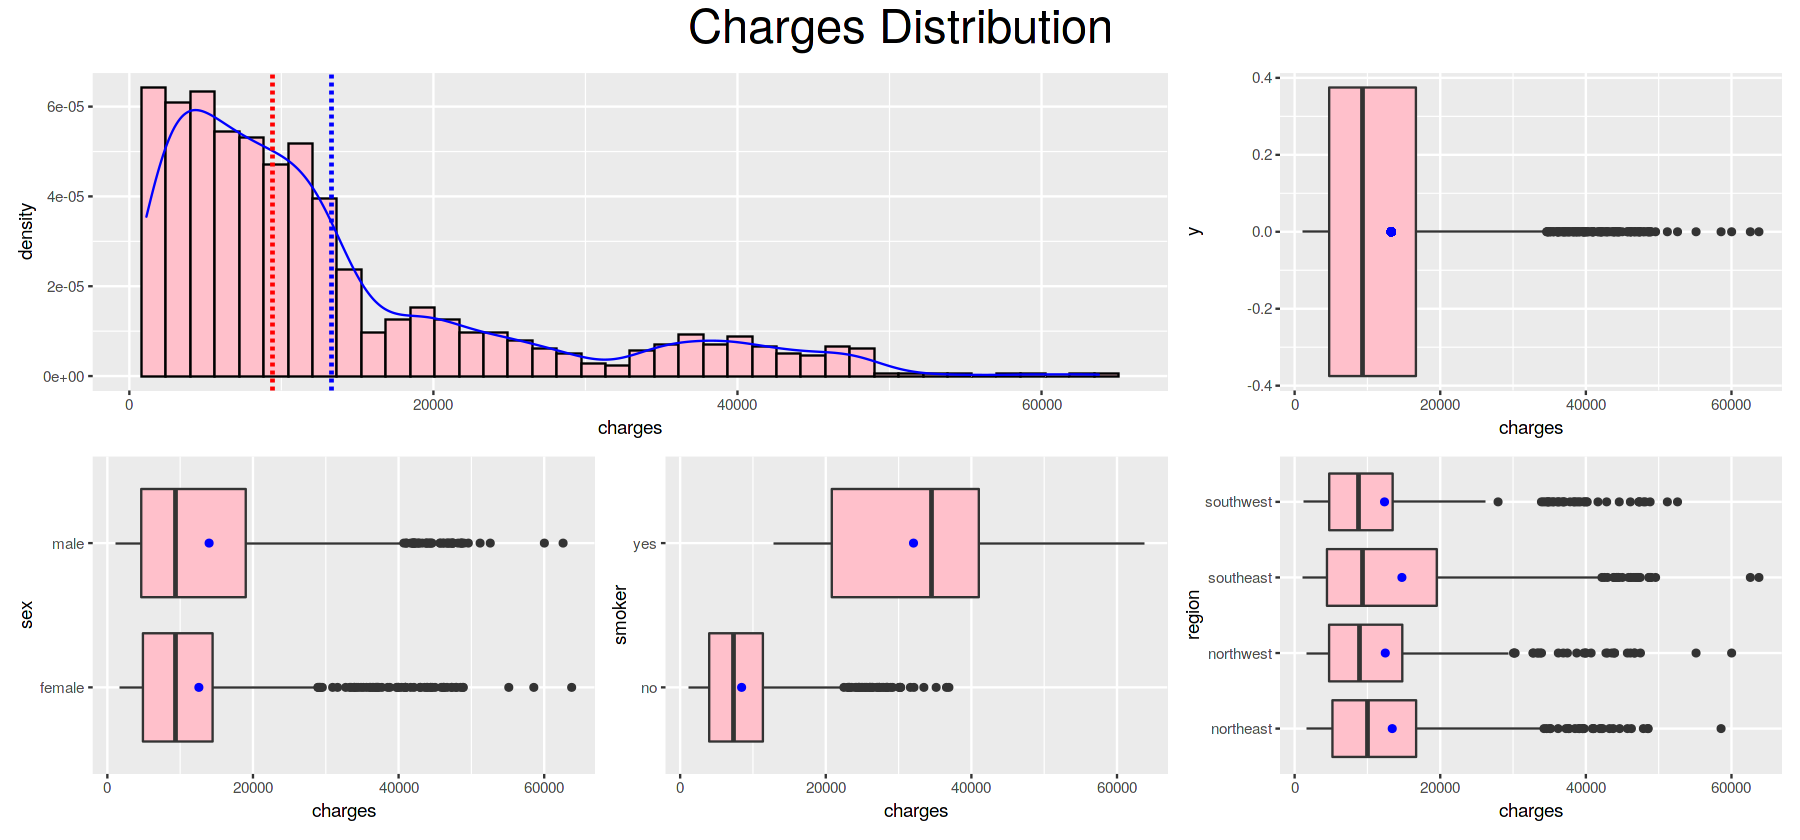

In [6]:
p1 <- ggplot(data, aes(x=charges)) +
    geom_histogram(aes(y=..density..),color="black", fill="pink", bins=40) +
    geom_density(color="blue") +
    geom_vline(aes(xintercept= mean(charges)), color="blue", linetype="dashed", size=1) +
    geom_vline(aes(xintercept= median(charges)), color="red", linetype="dashed", size=1)

p2 <- ggplot(data, aes(x = charges)) +
      geom_boxplot(fill = "pink") +
        geom_point(aes(x= mean(charges), y=0), color="blue")

p3 <- ggplot(data, aes(x=sex, y=charges, group=sex)) +
    geom_boxplot(fill="pink") +
    stat_summary(fun=mean, geom="point", color="blue") +
    coord_flip()

p4 <- ggplot(data, aes(x=smoker, y=charges, group=smoker)) +
    geom_boxplot(fill="pink") +
    stat_summary(fun=mean, geom="point", color="blue") +
    coord_flip() 

p5 <- ggplot(data, aes(x=region, y=charges, group=region)) +
    geom_boxplot(fill="pink") +
    stat_summary(fun=mean, geom="point", color="blue") +
    coord_flip()


options(repr.plot.width=15, repr.plot.height=7)
layout<- "AAB \n CDE"
p1 + p2 + p3 + p4 + p5 + plot_layout(design = layout) +
    plot_annotation(title="Charges Distribution", theme = theme(plot.title = element_text(size = 28, hjust = 0.5)))

The distribution is right-skewed with a long tail to the right. There’s a bump at around $\$40,000$, perhaps another hidden distribution. To dig this up, we need categorical features that we are going to explore.

There does not seems to be a significant difference in the median charges due to variables Sex and Region if not some slightly difference in charges between males and females, and between the southest region and the others. However smoking habit is a very important factor determining charge. The median charge for smokers is more than double the median insurance charges of non smokers.

Below a plot for the log transformation of the charges: It helps have a normal distribution which could help us in a number of different ways such as outlier detection, and for our predictive modell in the next section.

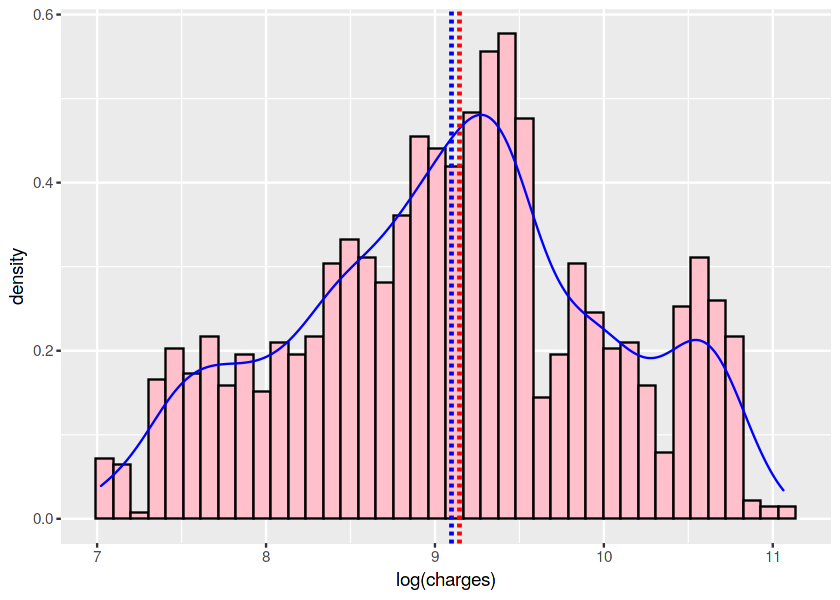

In [7]:
options(repr.plot.width=7, repr.plot.height=5)
ggplot(data, aes(x=log(charges))) +
    geom_histogram(aes(y=..density..),color="black", fill="pink", bins=40) +
    geom_density(color="blue") +
    geom_vline(aes(xintercept= mean(log(charges))), color="blue", linetype="dashed", size=1) +
    geom_vline(aes(xintercept= median(log(charges))), color="red", linetype="dashed", size=1)

Let’s draw again the distribution of charges, now categorizing them into smoker.

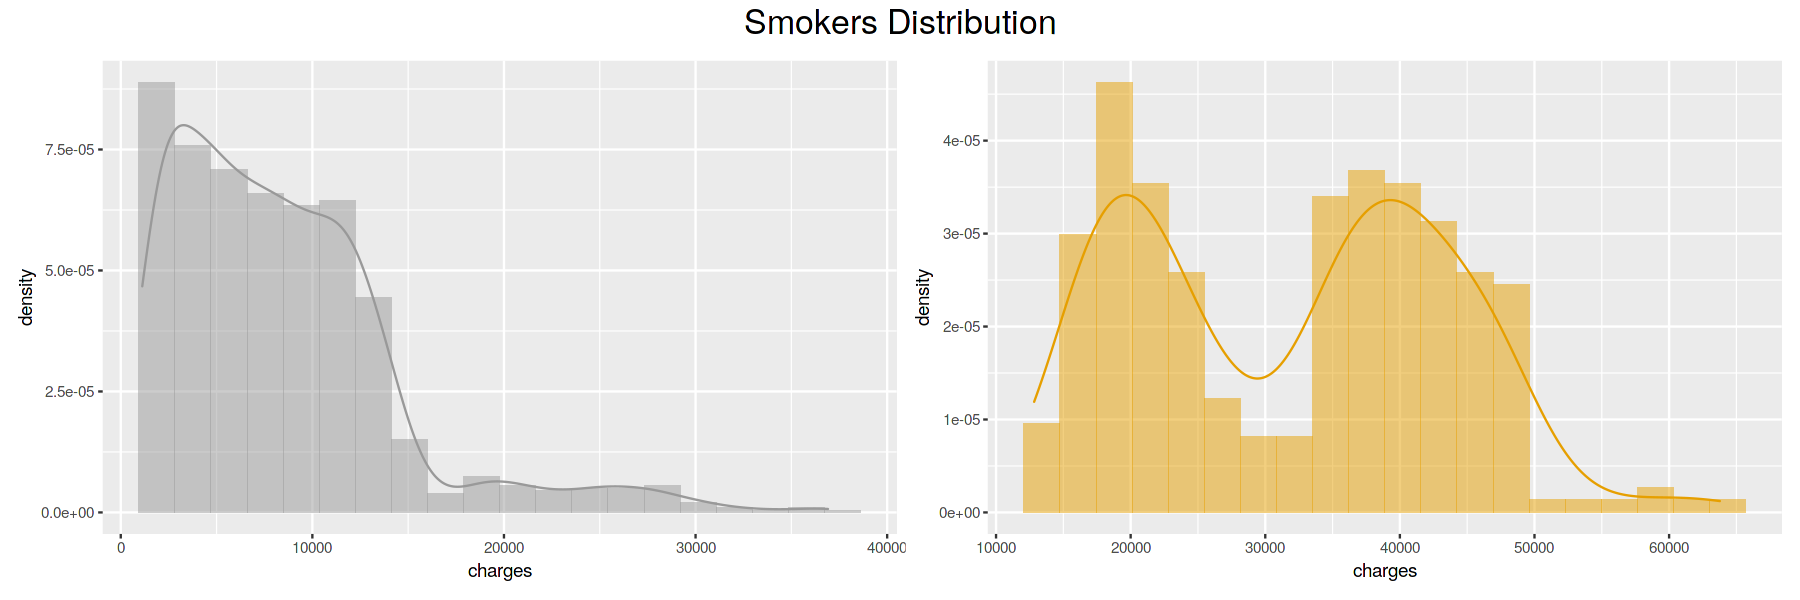

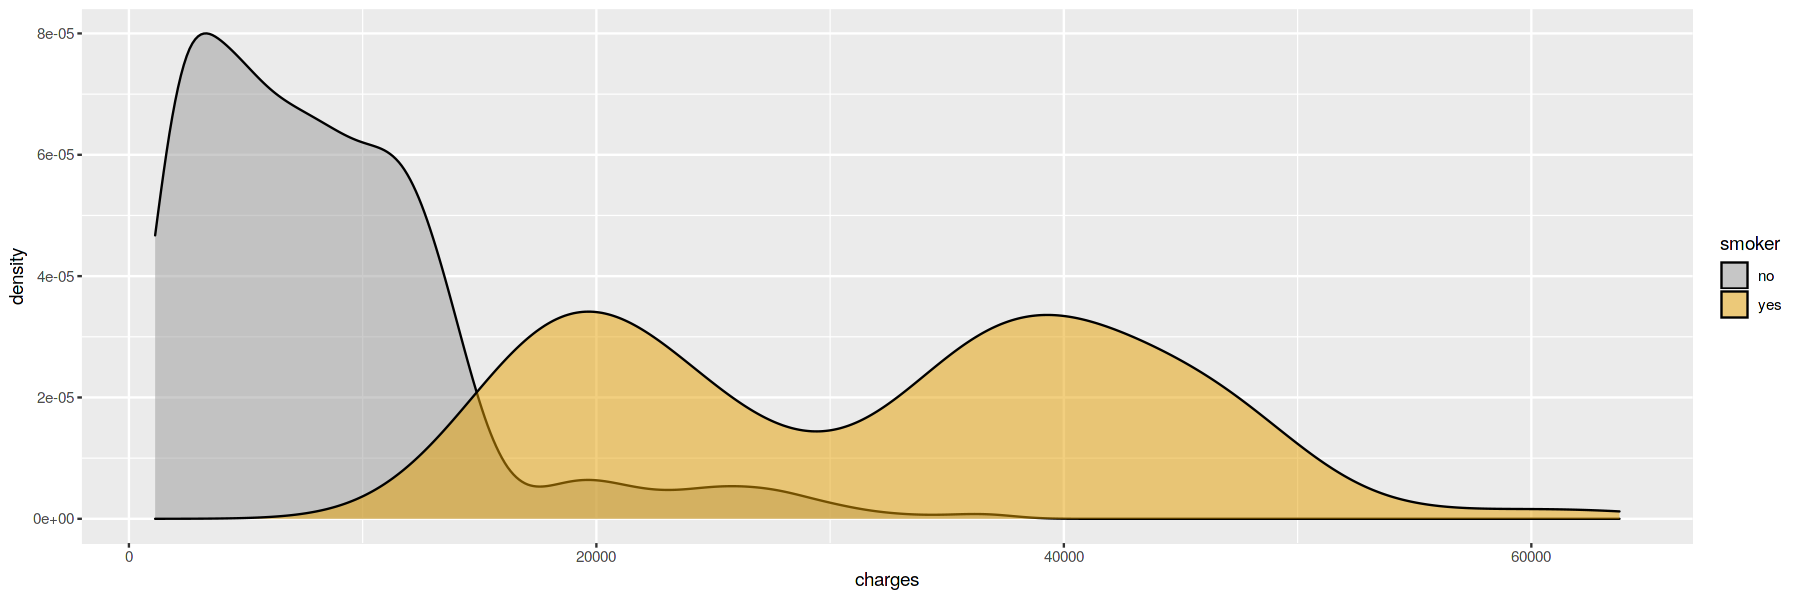

In [8]:
options(repr.plot.width=15, repr.plot.height=5)

smokers.color <- c("#999999", "#E69F00") #1 for non smokers, 2 for smokers

p1 <- ggplot(data[data$smoker == "no",], aes(x=charges, y= ..density..))+
    geom_histogram(fill=smokers.color[1],bins=20, alpha=.5)+
    geom_density(color=smokers.color[1])

p2 <- ggplot(data[data$smoker == "yes",], aes(x=charges, y= ..density..))+
    geom_histogram(fill=smokers.color[2],bins=20, alpha=.5)+
    geom_density(color=smokers.color[2])

p3 <- ggplot(data, aes(x = charges, fill = smoker)) + 
      geom_density(alpha = 0.5) + 
     scale_fill_manual(values=smokers.color)

p1 + p2 +
    plot_annotation(title="Smokers Distribution", theme = theme(plot.title = element_text(size = 20, hjust = 0.5)))
p3

Smokers definitely have more charges than non-smokers. That is a clear explanation of the bump in charges we have seen before.

About the sligtly differences of charges in gender and region mentioned above, below we are going to make some hypotesis testing to see if these are relevant factors.

### Hypotesys test 1:
We want to test the equality in the means of male and female smokers performing a statistical t-test. Since the salmples is enough large we assume the normality of the distribution. Before checking for the means, this test requires the two populations to be equal in the variance, so, a F-statistic will be perfomed taking in consideration: $\sigma_m$ the standard deviation of charge costs for male smokers, and $\sigma_f$ the standard deviation of charger costs for female smokers and let us define the two hypotesis:

* $H_0$ : $\sigma_m = \sigma_f$ 
* $H_1$ : $\sigma_m \neq \sigma_f$

In [9]:
male_smokers <- data %>%
        group_by(sex) %>%
        filter(sex == "male", smoker == "yes")
       
female_smokers <- data %>%
        group_by(sex) %>%
        filter(sex == "female", smoker == "yes")

males <- male_smokers$charges
females <- female_smokers$charges

var.test(males, females, alternative="two.sided")


	F test to compare two variances

data:  males and females
F = 0.88511, num df = 158, denom df = 114, p-value = 0.4762
alternative hypothesis: true ratio of variances is not equal to 1
95 percent confidence interval:
 0.6256613 1.2402158
sample estimates:
ratio of variances 
         0.8851142 


The p-value for the F-test is higher than the p-value, so we can accept the null hypotesis for which we have equal variance and perform a t-test on the means.  
Let us define $\mu_m$ the mean of charge costs for smoker males, and $\mu_f$ the mean of charger costs for smoker females
* $H_0$ : $\mu_m \leq \mu_f$ 
* $H_1$ : $\mu_m > \mu_f$

In [10]:
t.test(males, females, alternative = "greater", var.equal = FALSE)


	Welch Two Sample t-test

data:  males and females
t = 1.6617, df = 236.69, p-value = 0.04895
alternative hypothesis: true difference in means is greater than 0
95 percent confidence interval:
 14.73576      Inf
sample estimates:
mean of x mean of y 
 33042.01  30679.00 


The **p-value** of the test is a little less than the significance level $\alpha = 0.05$. So we can conclude that men smoker's average in charges is significantly greater than the women smoker's one.

Then $H_0$ is rejected.

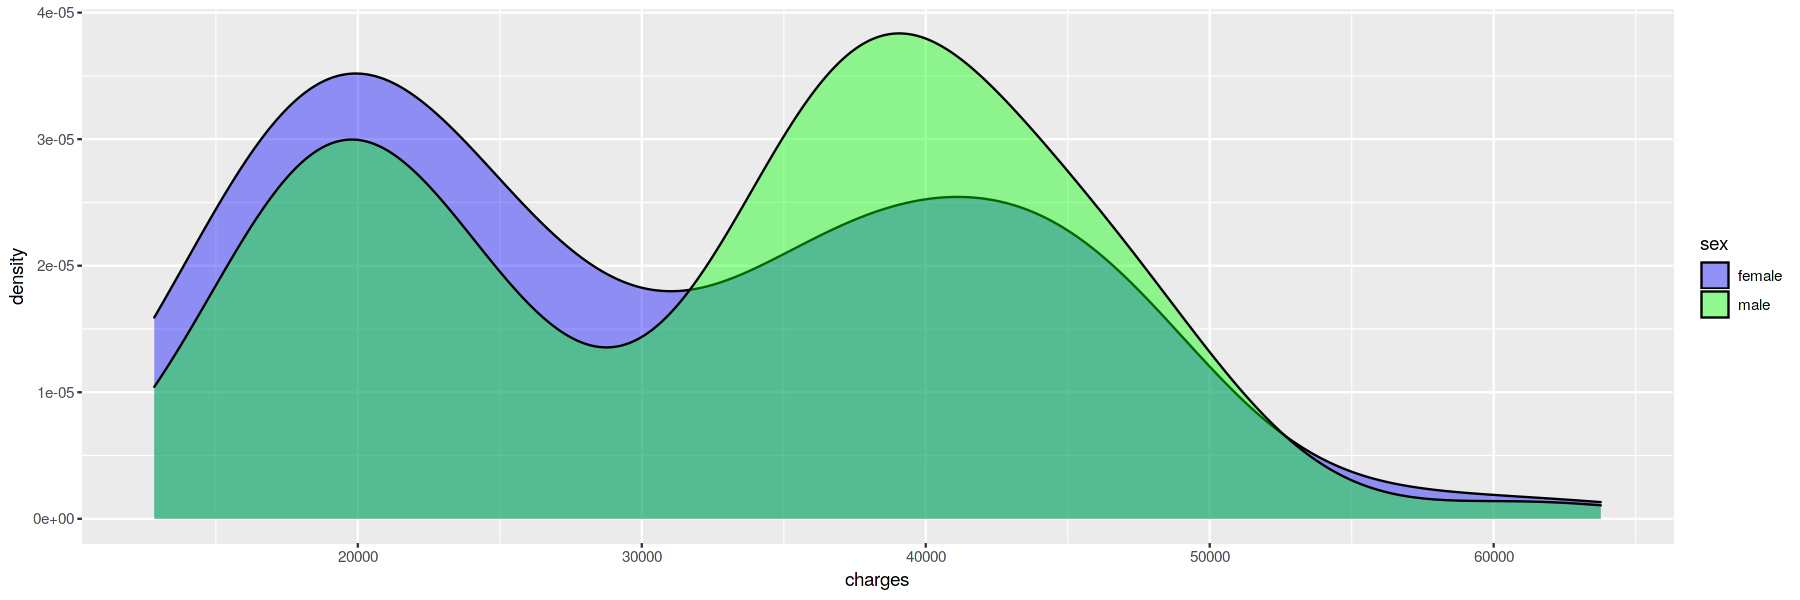

In [11]:
ggplot(data[data$smoker == "yes",], aes(x = charges, fill = sex)) + 
      geom_density(alpha = 0.4) + 
      scale_fill_manual(values=c("blue", "green"))

And there we can see a bump for males compared to female smokers where the difference is pretty clear. 

### Hypotesis test 2
Let us perform a Bartlett Test to check the homogenity of the variance of charges between the regions before going to test the equality on the mean:
* $H_0$ : $\sigma_{ne} = \sigma_{nw} =\sigma_{se} =\sigma_{sw}$

In [12]:
bartlett.test(charges ~ region, data = data)


	Bartlett test of homogeneity of variances

data:  charges by region
Bartlett's K-squared = 25.86, df = 3, p-value = 1.02e-05


In [13]:
bartlett.test(log(charges) ~ region, data = data)


	Bartlett test of homogeneity of variances

data:  log(charges) by region
Bartlett's K-squared = 17.705, df = 3, p-value = 0.000506


It seems that even applying a log transformation the charges, the P-value remains under the significance level, meaning that we have to reject the (null) hypotesis of equal variance, that is needed for the ANOVA test

Below the plots showing the shapes of charges ~ region and log(charges) ~ region

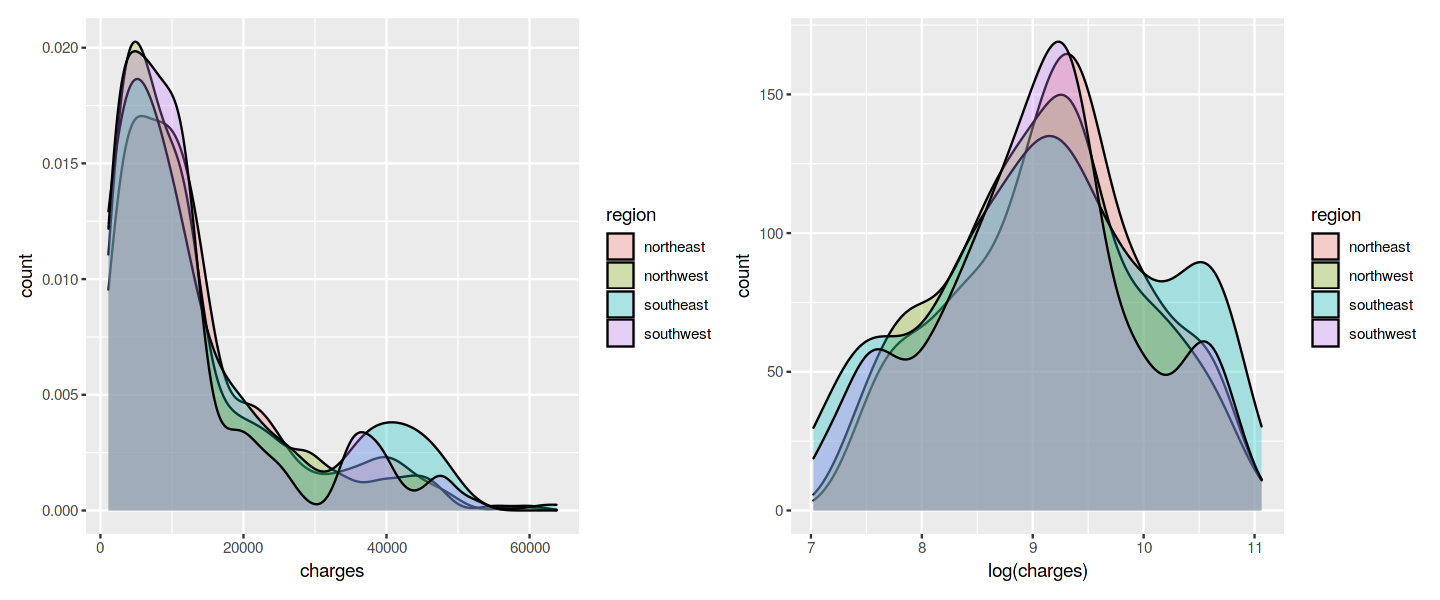

In [14]:
options(repr.plot.width=12, repr.plot.height=5)
p1 <- ggplot(data, aes(x=charges, y=..count.., fill=region))+
geom_density(alpha=0.3)
p2 <- ggplot(data, aes(x=log(charges), y=..count.., fill=region))+
geom_density(alpha=0.3)

p1 + p2

## Distributions on Numerical variables
Let us now inspect the distribution of the numerical variables and the relations with the categorical ones

### Age distributions

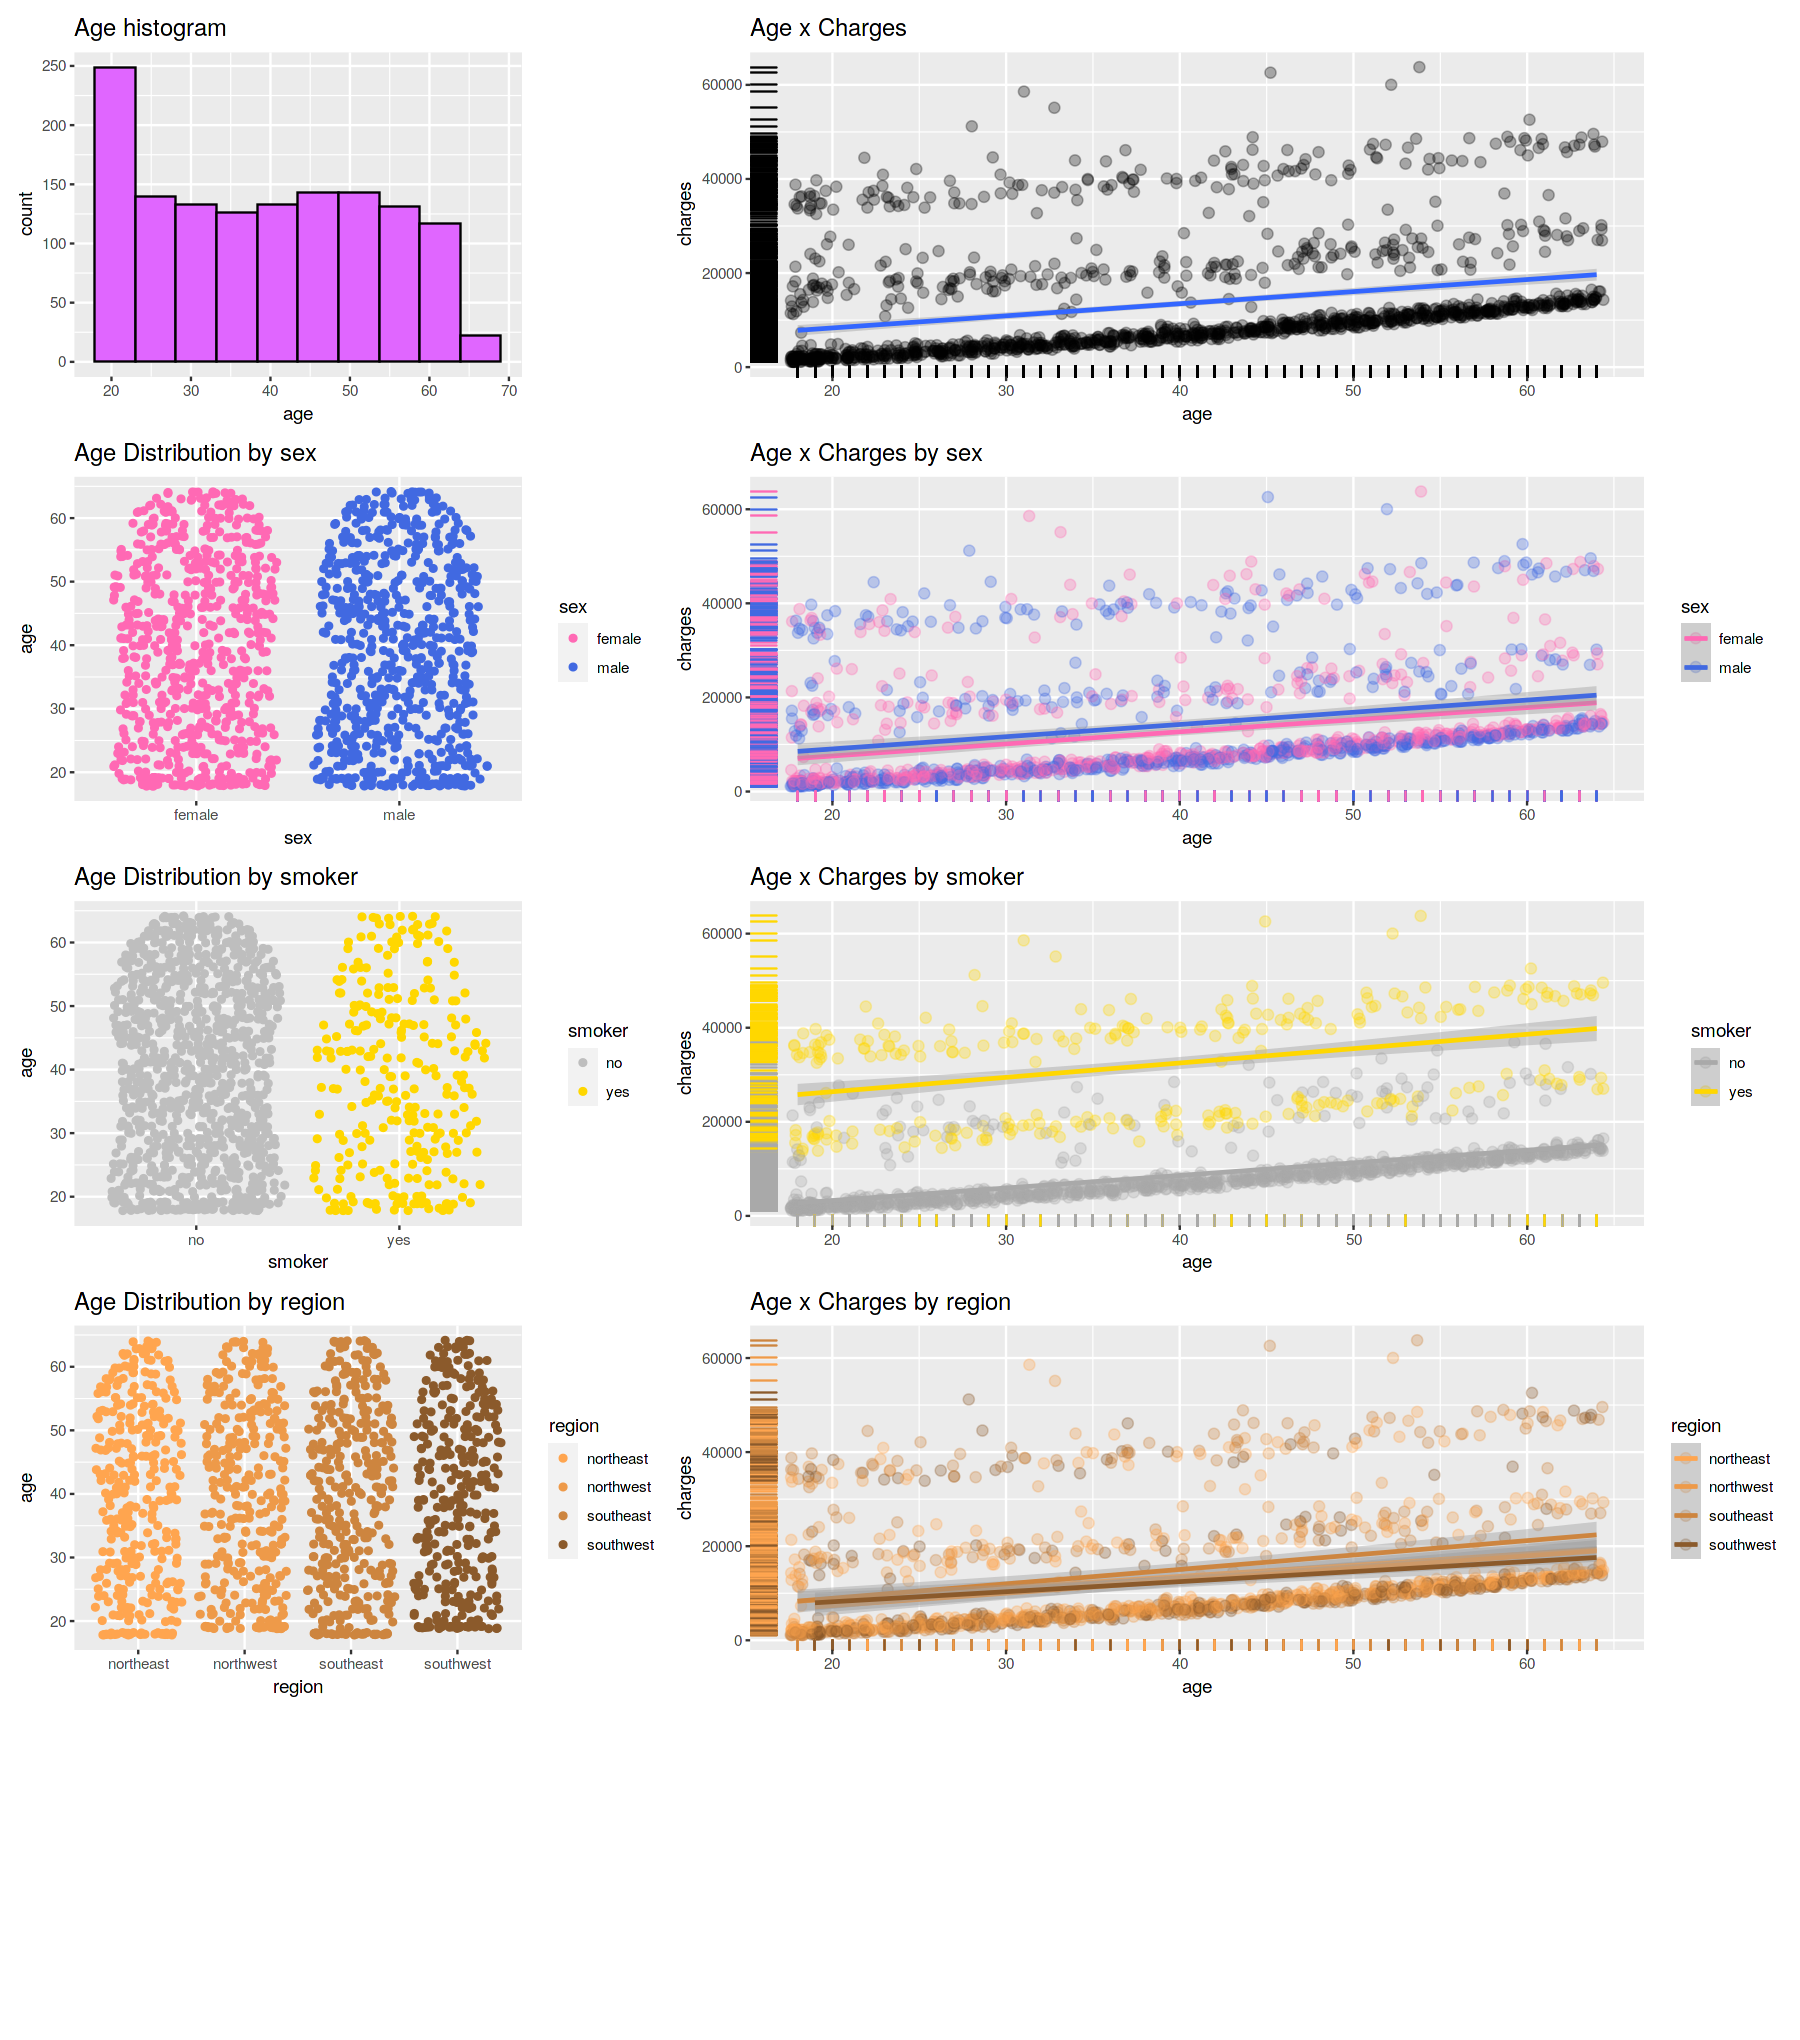

In [15]:
p1 <- ggplot(data, aes(x=age)) +
    geom_histogram(color="black", fill="mediumorchid1", bins=10) +
    labs(title="Age histogram") +
    theme(plot.title = element_text(size=14))

p2 <- ggplot(data, aes(x=age, y=charges)) +
    geom_jitter(alpha=0.3, size=2.5) +
    scale_color_manual("pink") +
    geom_rug() +
    geom_smooth(method=lm, formula=y~x) +
    labs(title="Age x Charges") +
    theme(plot.title = element_text(size=14))

### age, charges, sex
p3 <- ggplot(data, aes(x=sex, y=age, color=sex)) +
    geom_sina() +
    scale_color_manual(values=c('hotpink', "royalblue")) +
    labs(title="Age Distribution by sex") +
    theme(plot.title = element_text(size=14))

p4 <- ggplot(data, aes(x=age, y=charges, color= sex)) +
    geom_jitter(alpha=0.3, size=2.5) +
    scale_color_manual(values=c('hotpink', "royalblue")) +
    geom_rug() +
    geom_smooth(method=lm, formula=y~x) +
    labs(title="Age x Charges by sex") +
    theme(plot.title = element_text(size=14))

### age, charges, smoker
p5 <- ggplot(data, aes(x=smoker, y=age, color=smoker)) +
    geom_sina() +
    scale_color_manual(values=c('grey', "gold")) +
    labs(title="Age Distribution by smoker") +
    theme(plot.title = element_text(size=14))

p6 <- ggplot(data, aes(x=age, y=charges, color= smoker)) +
    geom_jitter(alpha=0.3, size=2.5) +
    scale_color_manual(values=c('darkgrey', "gold")) +
    geom_rug() +
    geom_smooth(method=lm, formula=y~x) +
    labs(title="Age x Charges by smoker") +
    theme(plot.title = element_text(size=14))

### age, charges, region
p7 <- ggplot(data, aes(x=region, y=age, color=region)) +
    geom_sina() +
    scale_color_manual(values=c('tan1', "tan2", 'tan3', "tan4")) +
    labs(title="Age Distribution by region") +
    theme(plot.title = element_text(size=14))

p8 <- ggplot(data, aes(x=age, y=charges, color= region)) +
    geom_jitter(alpha=0.3, size=2.5) +
    scale_color_manual(values=c('tan1', "tan2", 'tan3', "tan4")) +
    geom_rug() +
    geom_smooth(method=lm, formula=y~x) +
    labs(title="Age x Charges by region") +
    theme(plot.title = element_text(size=14))


options(repr.plot.width=15, repr.plot.height=17)
layout <- "ABB \n CDD \n EFF \n GHH \n IJJ"
p1 + p2 + p3 + p4+ p5 + p6+ p7+ p8+ plot_layout(design = layout)

The first histogram shows us an skewed distribution characterized form an higher number of person about 20s.

Anyway the plots did not show particular details if not that the older the costumer the higher the charges and that the smoker status affect heavly the charges indiscriminately at any age. Moreover it is possible to notice a presence of a middle level of charges that will be better analyzed.

Let us explore now the distribution of sample's ages and see if we can find someting more interesting

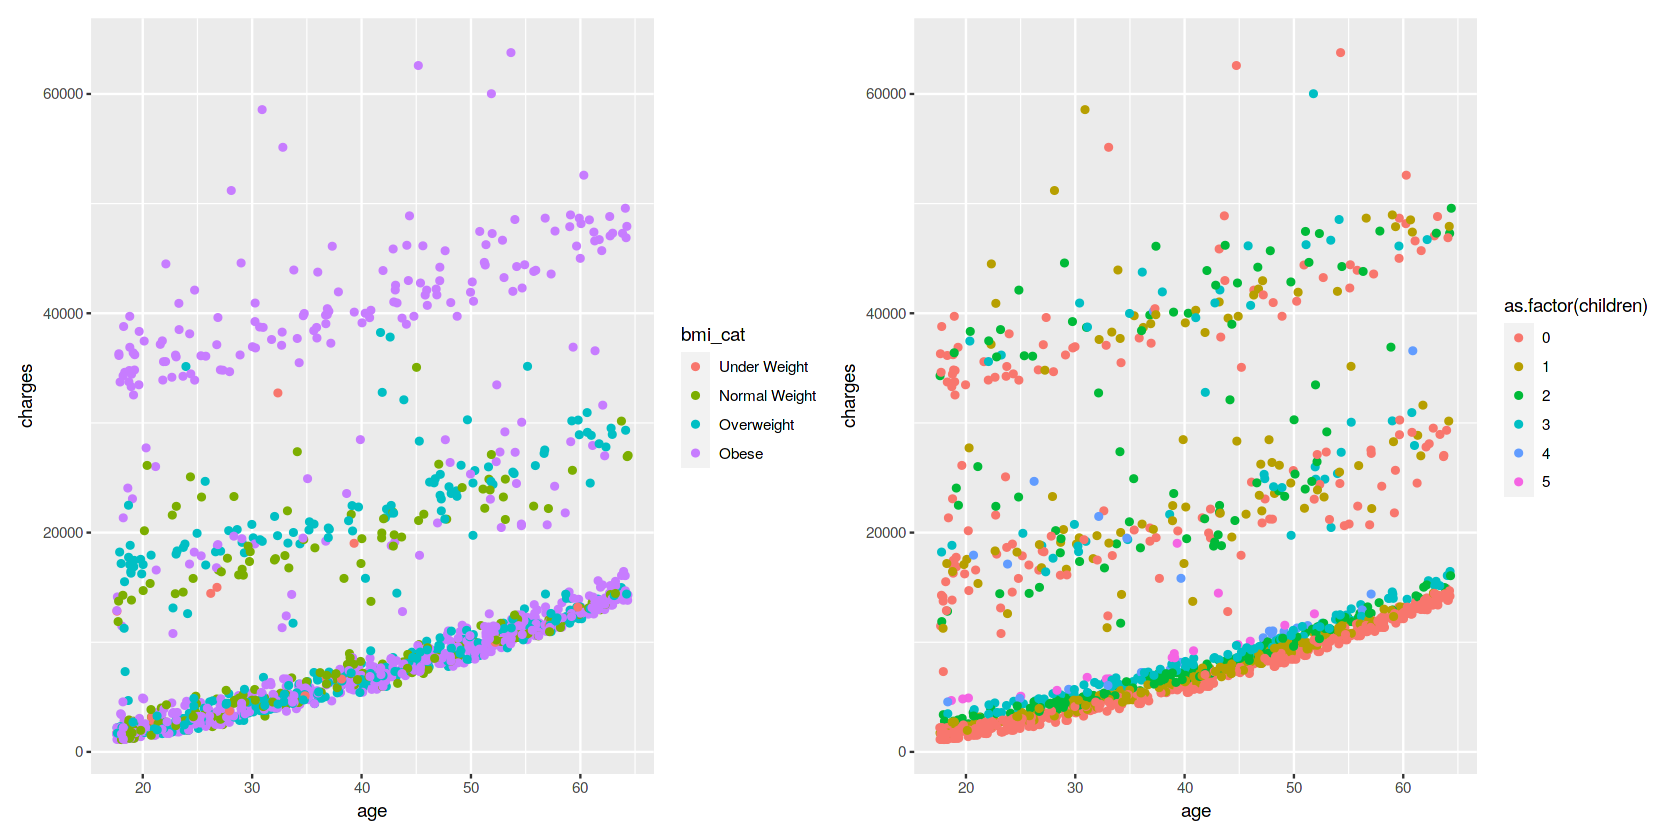

In [16]:
options(repr.plot.width=14, repr.plot.height=7)
data <- (data %>% mutate(bmi_cat = cut(data$bmi, breaks = c(0, 18.5, 25, 30, 60), labels = c("Under Weight", "Normal Weight", "Overweight", "Obese"))))

p1 <- ggplot(data, aes(x=age, y=charges, color=bmi_cat))+
    geom_jitter()

p2 <- ggplot(data, aes(x=age, y=charges, color=as.factor(children)))+
    geom_jitter()

p1 + p2

The number of children seems not to affect this behaviour, on the contrary, by discretizing the BMI values, we can notice that in the middle level of charges ~ age there is majority of **Overwheighted** to **Normalweighted** people that can explain this behaviour, let us dig a little more about this.

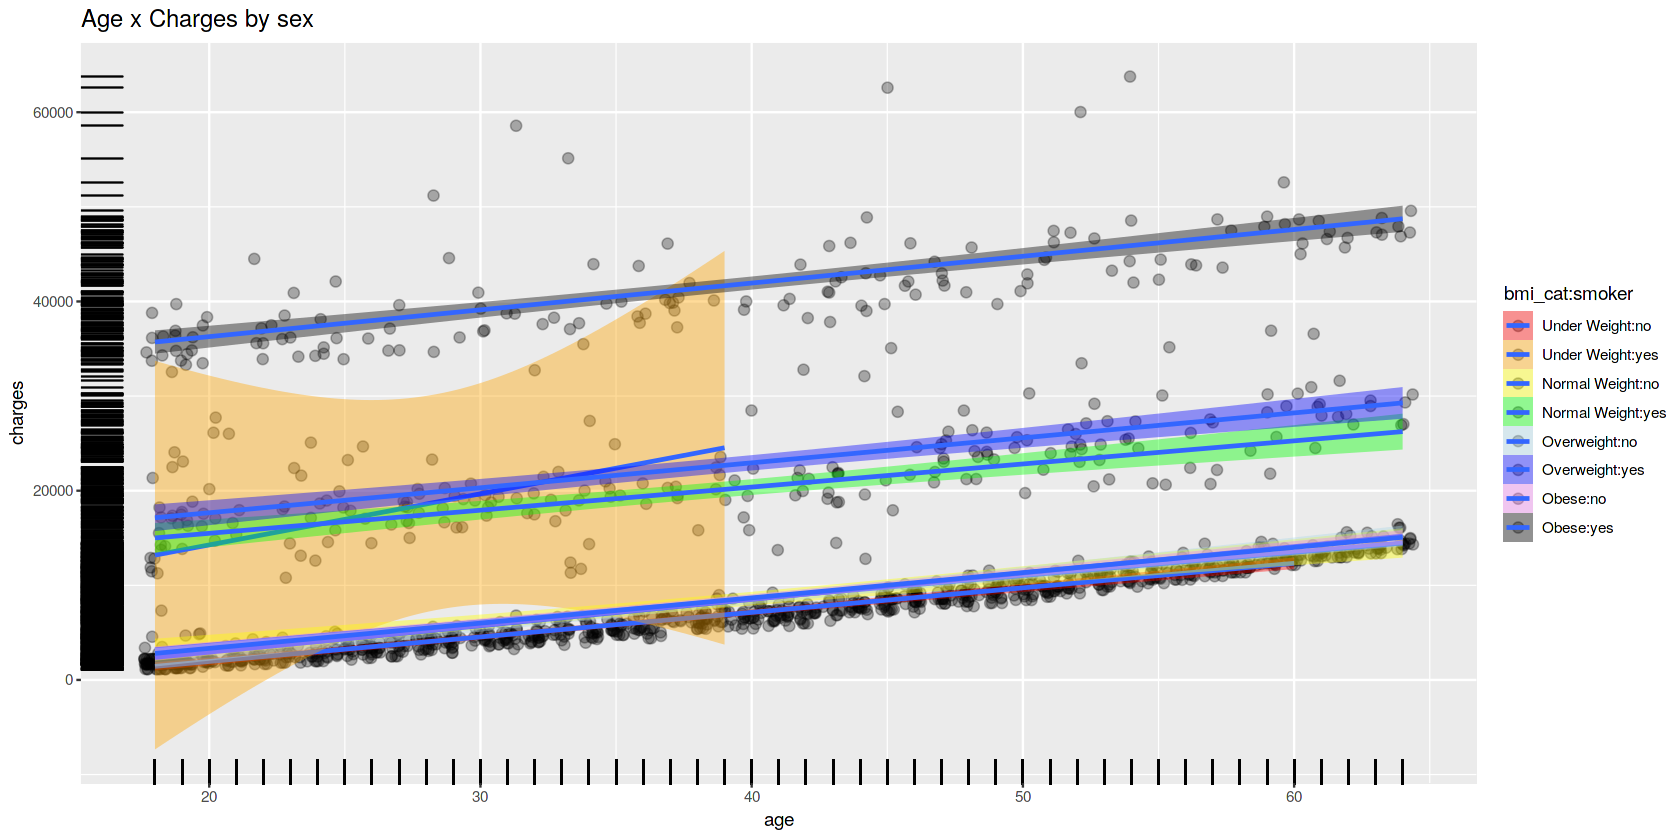

In [17]:
ggplot(data, aes(x=age, y=charges, fill= bmi_cat:smoker)) +
    geom_jitter(alpha=0.3, size=2.5) +
    scale_fill_manual(values=c("red","orange","yellow","green","lightblue","blue","violet","black")) +
    geom_rug() +
    geom_smooth(method=lm, formula=y~x) +
    labs(title="Age x Charges by sex") +
    theme(plot.title = element_text(size=14))

data$bmi_cat <- NULL

In fact we can notice that in the middle we can find a majority of Normal and Overweighted smokers, it is also interesting to notice that from 18 to almost 40 years old the Under Wheight smokers have a huge variability in the charges. By the way we are not going to investigate further on this factor.

### BMI Distributions

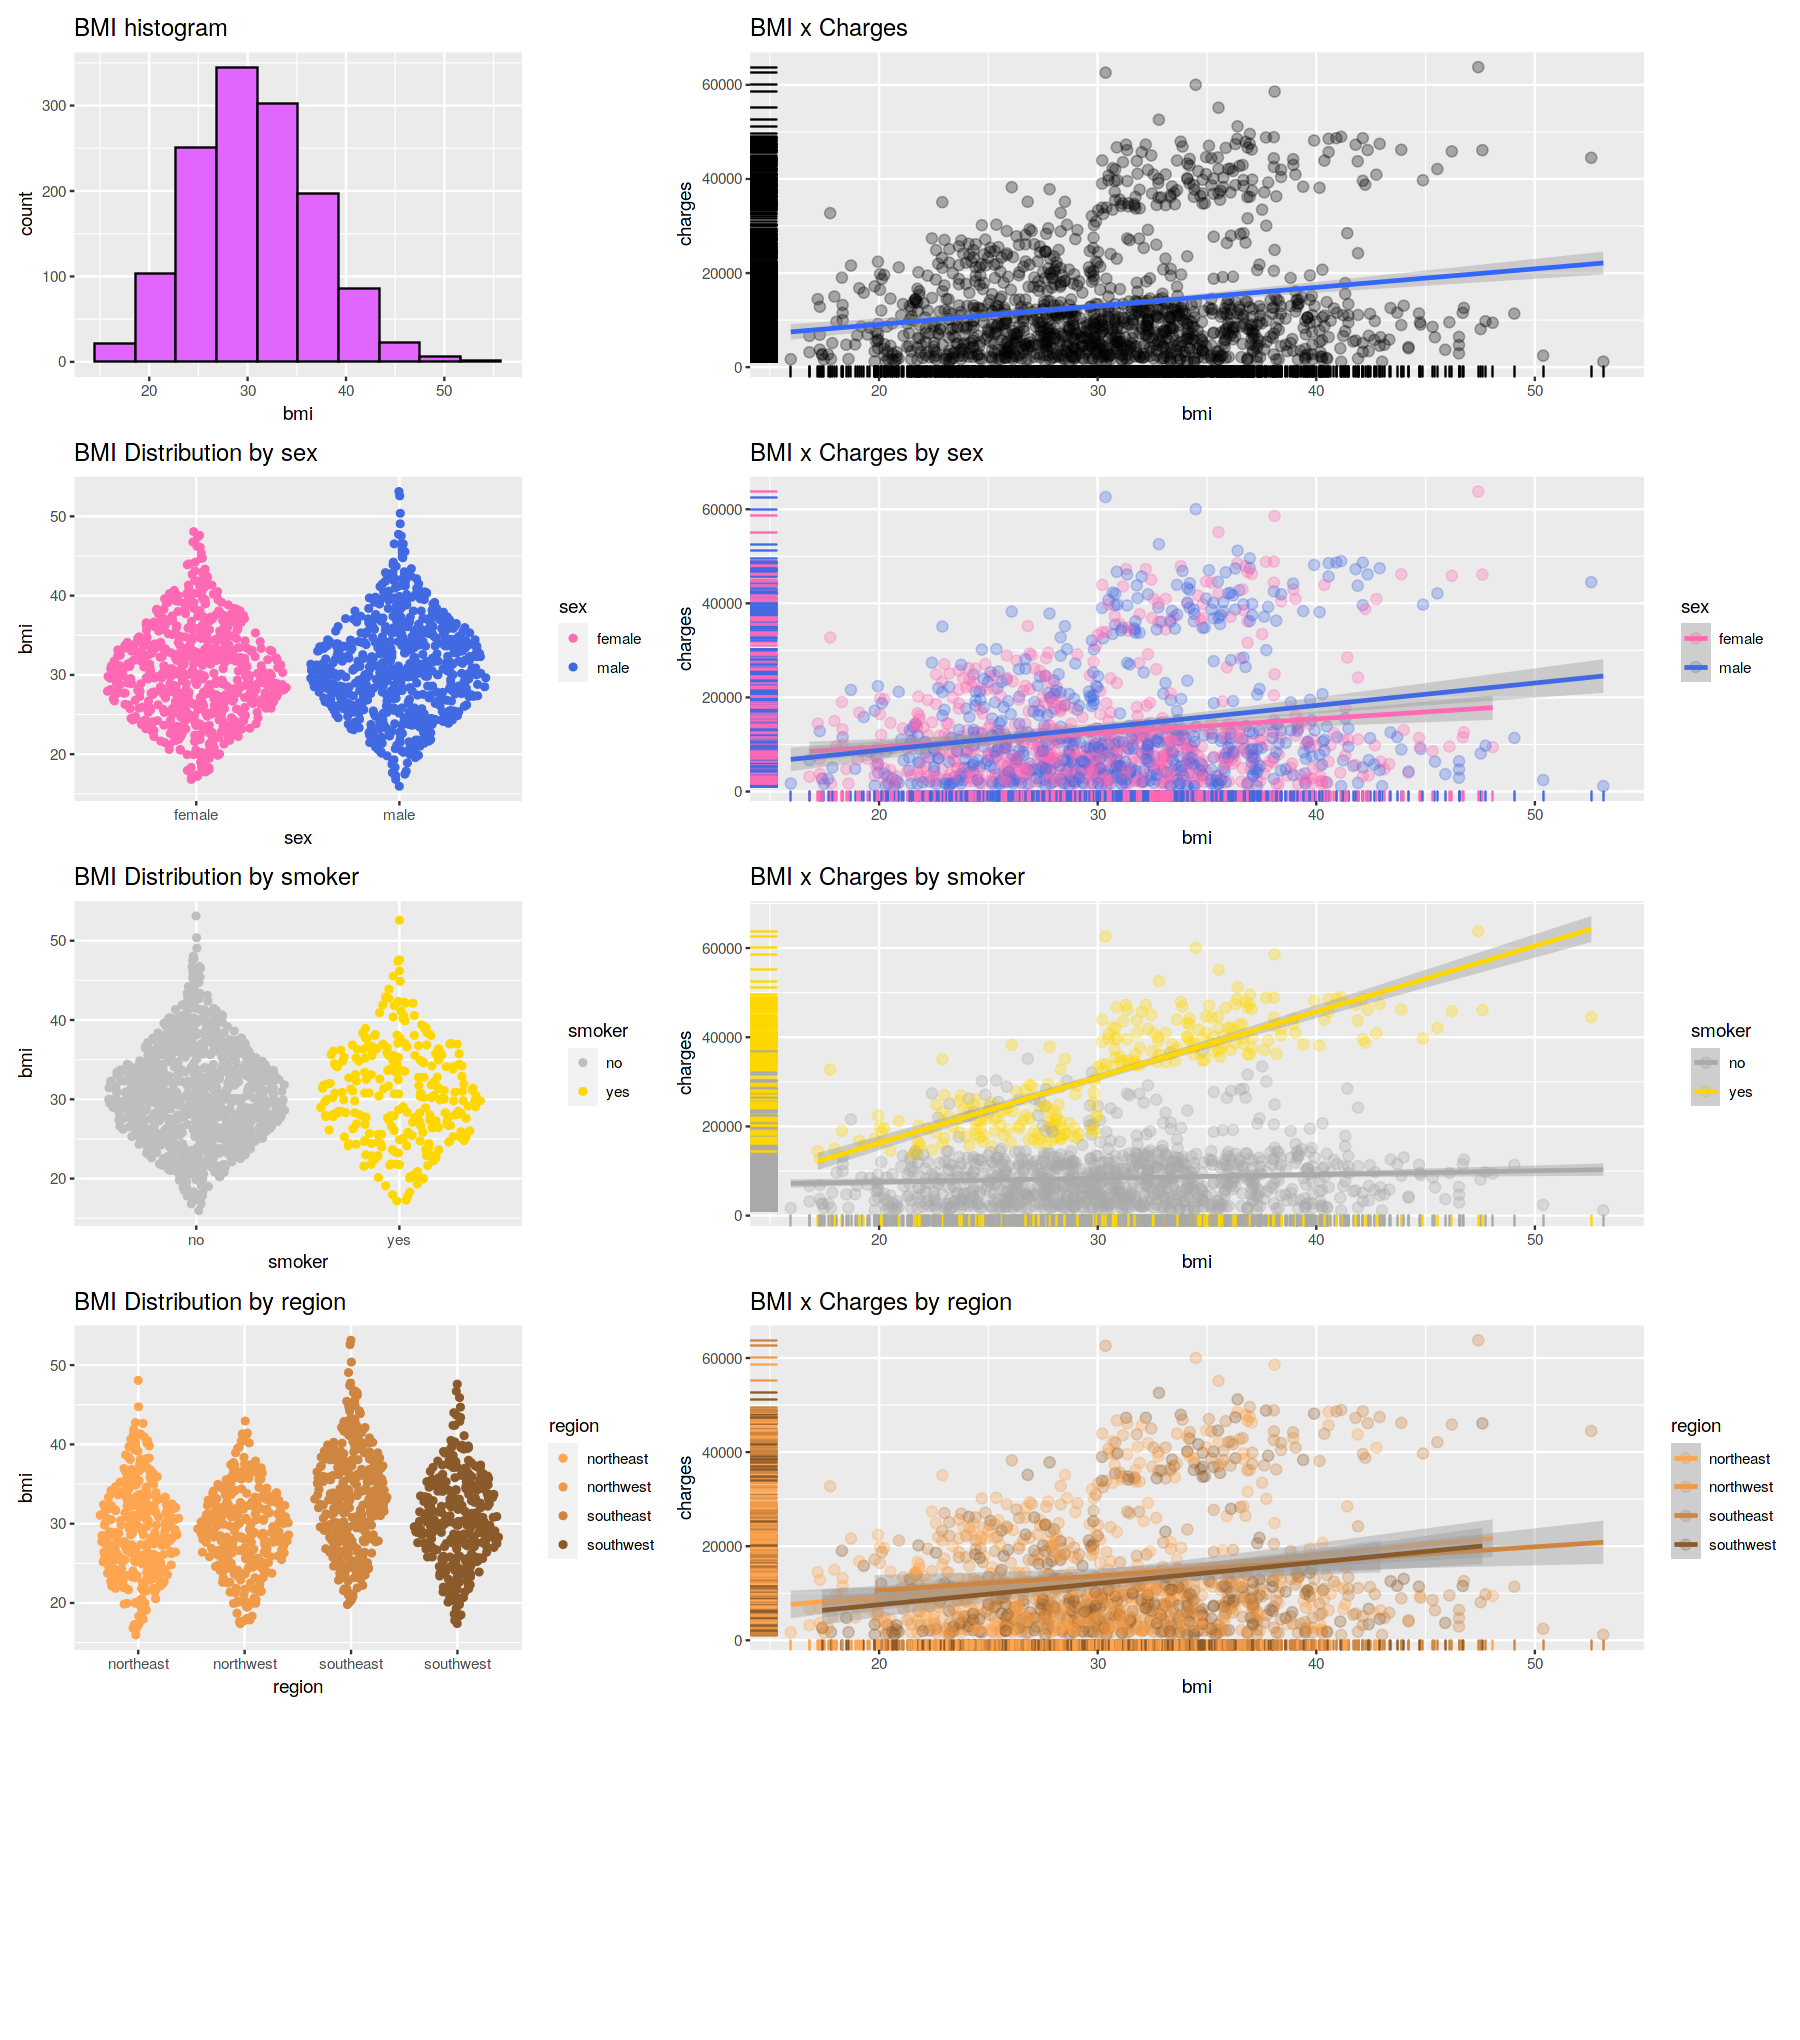

In [18]:
p1 <- ggplot(data, aes(x=bmi))+
    geom_histogram(color="black", fill="mediumorchid1", bins=10)+
    labs(title="BMI histogram" )+
    theme(plot.title = element_text(size=14))

p2 <- ggplot(data, aes(x=bmi, y=charges)) +
    geom_jitter(alpha=0.3, size=2.5) +
    scale_color_manual("mediumorchid1") +
    geom_rug() +
    geom_smooth(method=lm, formula=y~x) +
    labs(title="BMI x Charges") +
    theme(plot.title = element_text(size=14))

### bmi, charges, sex
p3 <- ggplot(data, aes(x=sex, y=bmi, color=sex)) +
    geom_sina() +
    scale_color_manual(values=c('hotpink', "royalblue")) +
    labs(title="BMI Distribution by sex") +
    theme(plot.title = element_text(size=14))

p4 <- ggplot(data, aes(x=bmi, y=charges, color= sex)) +
    geom_jitter(alpha=0.3, size=2.5) +
    scale_color_manual(values=c('hotpink', "royalblue")) +
    geom_rug() +
    geom_smooth(method=lm, formula=y~x) +
    labs(title="BMI x Charges by sex") +
    theme(plot.title = element_text(size=14))

### age, charges, smoker
p5 <- ggplot(data, aes(x=smoker, y=bmi, color=smoker)) +
    geom_sina() +
    scale_color_manual(values=c('grey', "gold")) +
    labs(title="BMI Distribution by smoker") +
    theme(plot.title = element_text(size=14))

p6 <- ggplot(data, aes(x=bmi, y=charges, color= smoker)) +
    geom_jitter(alpha=0.3, size=2.5)+
    scale_color_manual(values=c('darkgrey', "gold")) +
    geom_rug()+
    geom_smooth(method=lm, formula=y~x) +
    labs(title="BMI x Charges by smoker") +
    theme(plot.title = element_text(size=14))

### age, charges, region
p7 <- ggplot(data, aes(x=region, y=bmi, color=region)) +
    geom_sina() +
    scale_color_manual(values=c('tan1', "tan2", 'tan3', "tan4")) +
    labs(title="BMI Distribution by region") +
    theme(plot.title = element_text(size=14))

p8 <- ggplot(data, aes(x=bmi, y=charges, color= region)) +
    geom_jitter(alpha=0.3, size=2.5) +
    scale_color_manual(values=c('tan1', "tan2", 'tan3', "tan4")) +
    geom_rug() +
    geom_smooth(method=lm, formula=y~x) +
    labs(title="BMI x Charges by region") +
    theme(plot.title = element_text(size=14))


options(repr.plot.width=15, repr.plot.height=17)
layout<-"ABB \n CDD \n EFF \n GHH \n IJJ"
p1 + p2 + p3 + p4+ p5 + p6+ p7+ p8+ plot_layout(design = layout)

Comparing BMI~Charges with regard of the categorical values we can notice a clear increase of medical costs corresponding to the increase of BMI, with an important increase with the smoker status, and a higher BMI in the south est region, let us doing some statistical test to investigate about the significance of those last one:

### Hypotesis test 3:

Let us perform a Bartlett Test to check the homogenity of the variance of charges between the regions before going to test the equality on the mean:
* $H_0$ : $\sigma_{Bne} = \sigma_{Bnw} =\sigma_{Bse} =\sigma_{Bsw}$

In [19]:
bartlett.test(formula = bmi ~ region, data = data)


	Bartlett test of homogeneity of variances

data:  bmi by region
Bartlett's K-squared = 18.5, df = 3, p-value = 0.0003468


In [20]:
bartlett.test(formula = log(bmi) ~ region, data = data)


	Bartlett test of homogeneity of variances

data:  log(bmi) by region
Bartlett's K-squared = 6.2626, df = 3, p-value = 0.09951


Using a log transformation on the BMI it seems that we are able to get rid of the difference between the variances in the BMIs distributions per region, let us now perform an ANOVA test on the log(bmi) to check the equality of the mean.

* $H_0$ : $\mu_{Bne} = \mu_{Bnw} =\mu_{Bse} =\mu_{Bsw}$

In [21]:
log.bmi.aov <- aov(formula = log(bmi) ~ region, data = data)
summary(log.bmi.aov)

              Df Sum Sq Mean Sq F value Pr(>F)    
region         3   4.13   1.377    36.2 <2e-16 ***
Residuals   1333  50.69   0.038                   
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Nonetheless, the **p-value** results to be significantly lower than the significance level, than we reject the null hypotesis, meaning that at least one of the means is significantly different from the one of the other regions

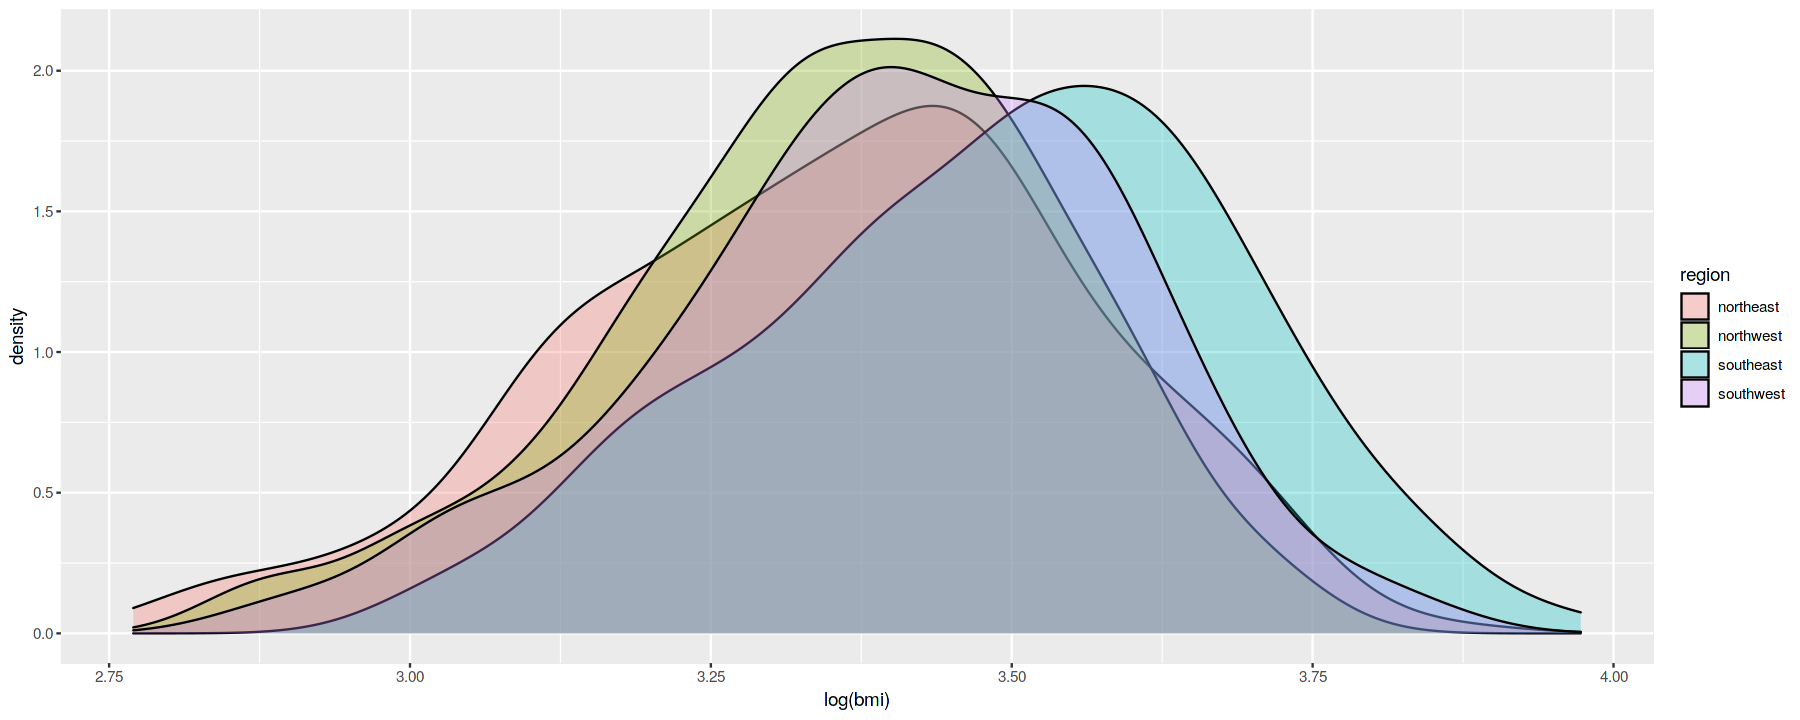

In [22]:
options(repr.plot.width=15, repr.plot.height=6)

ggplot(data, aes(x=log(bmi), fill=region))+
    geom_density(alpha=.3)

In fact seems that the southeast has a larger BMI compared to the other regions

### Children Distributions

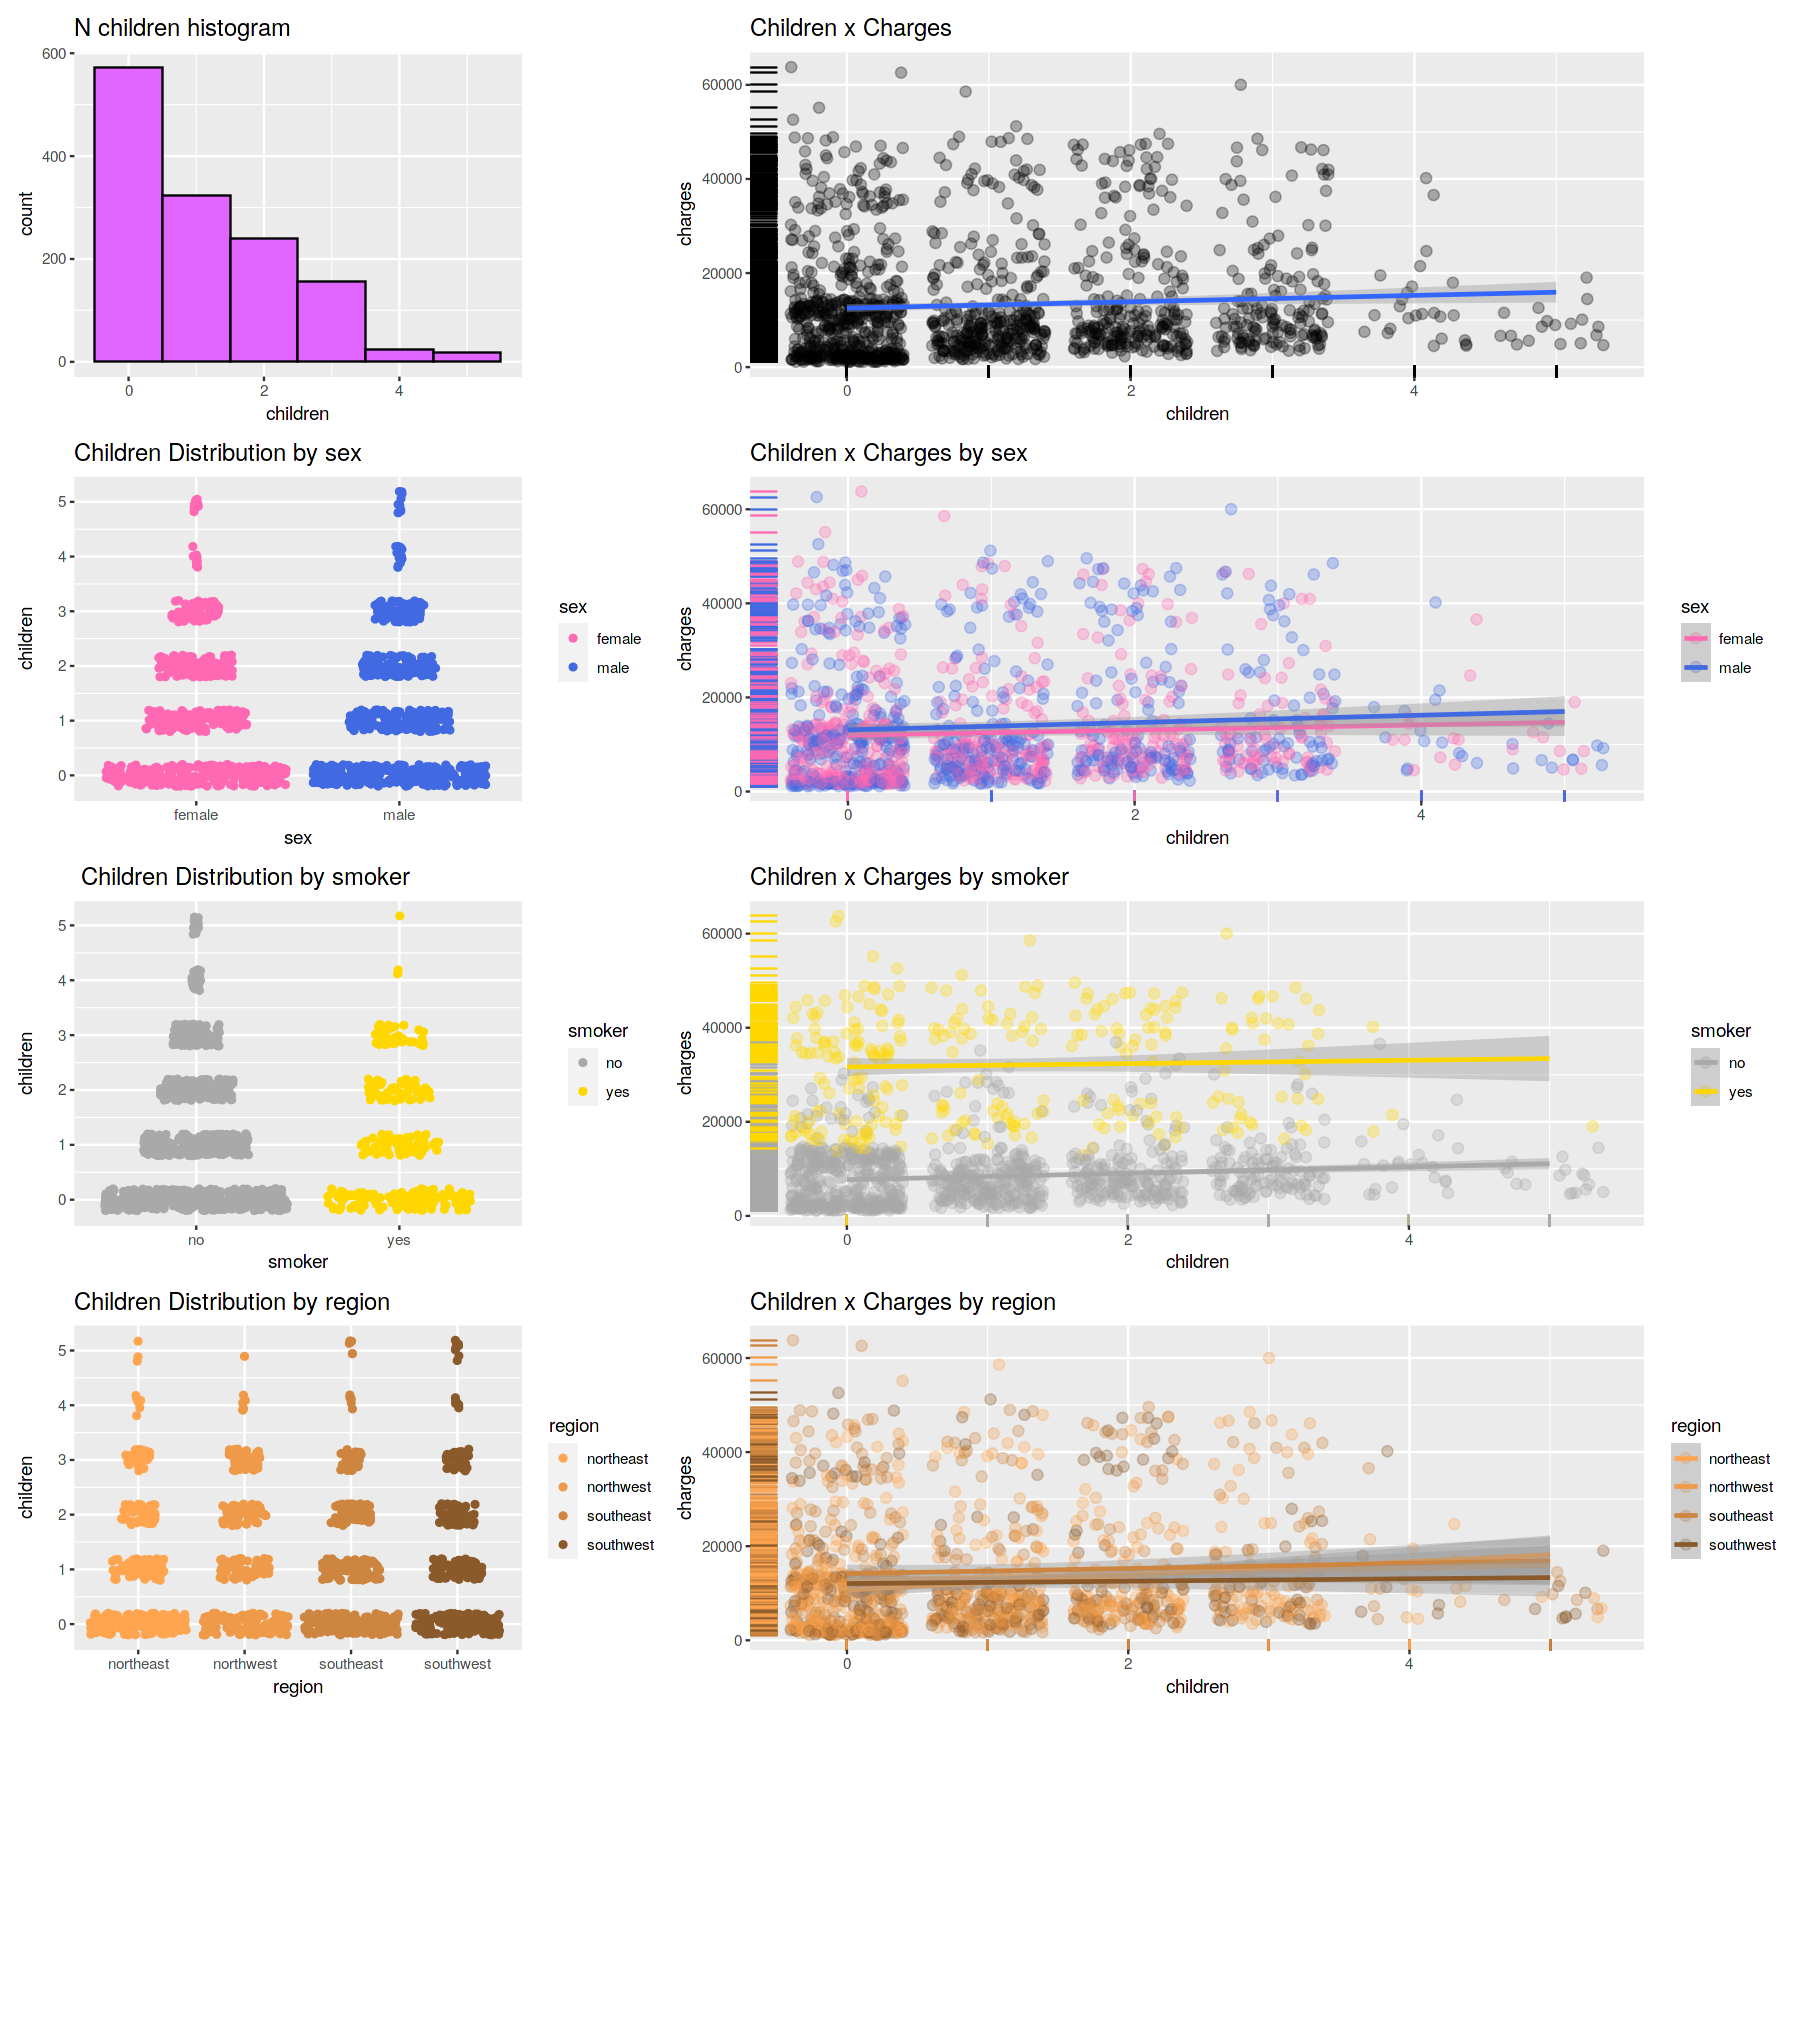

In [23]:
p1<-ggplot(data, aes(x=children)) +
    geom_histogram(color="black", fill="mediumorchid1", bins=6) +
    labs(title="N children histogram") +
    theme(plot.title = element_text(size=14))

p2<-ggplot(data, aes(x=children, y=charges)) +
    geom_jitter(alpha=0.3, size=2.5) +
    scale_color_manual("pink") +
    geom_rug() +
    geom_smooth(method=lm, formula=y~x) +
    labs(title="Children x Charges") +
    theme(plot.title = element_text(size=14))

### bmi, charges, sex
p3<-ggplot(data, aes(x=sex, y=children, color=sex)) +
    geom_sina() +
    scale_color_manual(values=c('hotpink', "royalblue")) +
    labs(title="Children Distribution by sex") +
    theme(plot.title = element_text(size=14))

p4<-ggplot(data, aes(x=children, y=charges, color= sex)) +
    geom_jitter(alpha=0.3, size=2.5) +
    scale_color_manual(values=c('hotpink', "royalblue")) +
    geom_rug() +
    geom_smooth(method=lm, formula=y~x) +
    labs(title="Children x Charges by sex") +
    theme(plot.title = element_text(size=14))

### age, charges, smoker
p5<-ggplot(data, aes(x=smoker, y=children, color=smoker)) +
    geom_sina() +
    scale_color_manual(values=c('darkgrey', "gold")) +
    labs(title=" Children Distribution by smoker") +
    theme(plot.title = element_text(size=14))

p6<-ggplot(data, aes(x=children, y=charges, color= smoker)) +
    geom_jitter(alpha=0.3, size=2.5) +
    scale_color_manual(values=c('darkgrey', "gold")) +
    geom_rug() +
    geom_smooth(method=lm, formula=y~x) +
    labs(title="Children x Charges by smoker") +
    theme(plot.title = element_text(size=14))

### age, charges, region
p7<-ggplot(data, aes(x=region, y=children, color=region)) +
    geom_sina() +
    scale_color_manual(values=c('tan1', "tan2", 'tan3', "tan4")) +
    labs(title="Children Distribution by region") +
    theme(plot.title = element_text(size=14))

p8<-ggplot(data, aes(x=children, y=charges, color= region)) +
    geom_jitter(alpha=0.3, size=2.5) +
    scale_color_manual(values=c('tan1', "tan2", 'tan3', "tan4")) +
    geom_rug() +
    geom_smooth(method=lm, formula=y~x) +
    labs(title="Children x Charges by region") +
    theme(plot.title = element_text(size=14))

options(repr.plot.width=15, repr.plot.height=17)
layout<-"ABB \n CDD \n EFF \n GHH \n IJJ"
p1 + p2 + p3 + p4+ p5 + p6+ p7+ p8+ plot_layout(design = layout)

In those last plots there not seems to be significant additional informations. We can just notice that the distribution is skewed to the right, maybe given by the high number of youngs that tends to have few or no children, charges increases with the number of children, and that people with more than 3 children tends to smoke less

## Correlations

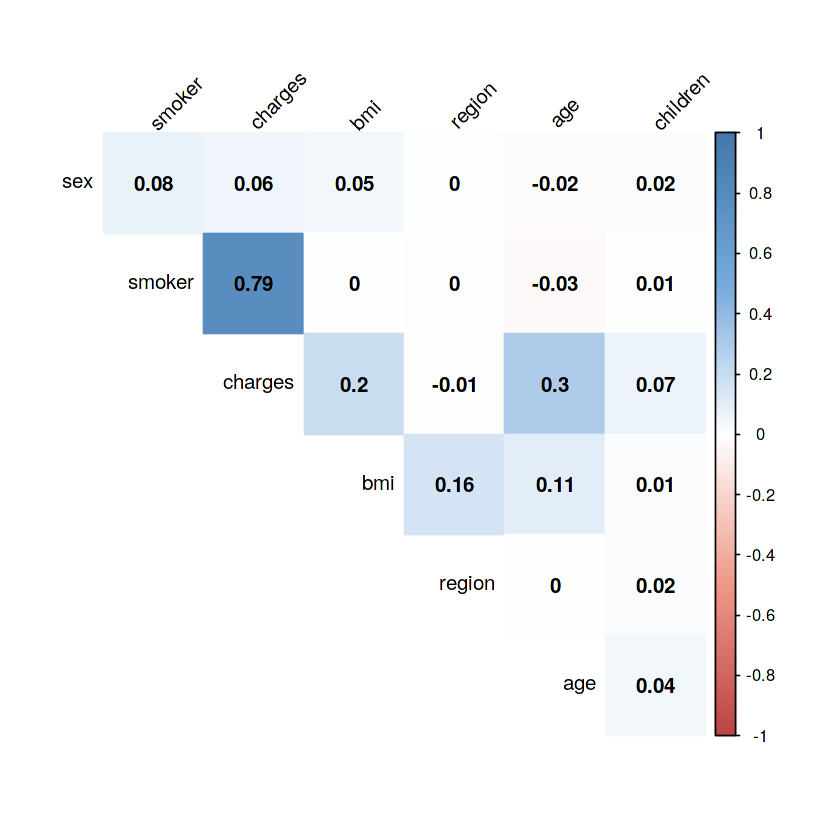

In [24]:
options(repr.plot.width=7, repr.plot.height=7)
corr <- cor(data %>% mutate_if(is.factor, as.numeric))

col <- colorRampPalette(c("#BB4444", "#EE9988", "#FFFFFF", "#77AADD", "#4477AA"))
corrplot(corr, method="color", col=col(200),  
         type="upper", order="hclust", 
         addCoef.col = "black", 
         tl.col="black", tl.srt=45, 
         sig.level = 0.01, insig = "blank", 
         diag=FALSE)

### Resuming:
It can be observed that smokers have a very high insurance charge and due to this, the points in the higher regions of all the plots drawn against charges are those of smokers. It seems to be the most important variable impacting charges due to which levels are visible in all the plots.  

From the correlation plot, it seems that the variables having the best correlation are the **smoker status** and the **charges**, there is almost no correlations between the other features


# Model data

After analyzing the behaviors of the dataset, we try to find the model that fits well. 

## Accuracy metrics
To assess the accuracy of the models we are going to implement we will make use of four metrics:
* Adjusted $R^2$: is based on R², which provides an indication of how well a model fits the data by adding predictors to the model. This addition decreases the effect of randomness on the R² value and provides more information on the issue of overfitting. We do not use R² because it has no meaning for non-linear models.
* Residual Standard Error (RSE): measures the likelihood that the model fit deviates from the actual population. Estimates with an RSE of 25% or higher are subject to high sampling error.
* Root Mean Squared Error (RMSE): is widely used in capturing large errors in data and it is sensitive to outliers it may not want to capture. It tends to increase as the complexity of the model increases (i.e. susceptible to overfitting).
* Akaike Information Criterion (AIC): measures both how well the data fits the model, and how complex it is. It penalizes a model for its complexity, but rewards it for how well it fits the data.

## Splitting of train data and test data  
We split the data into train (80%) and test (20%) using sampling from original data.

In [25]:
set.seed(42)

samp <- sample(1:nrow(data), ceiling(0.80*nrow(data)))
train <- data[samp,]
test <- data[-samp,]

## Linear Regression 1

For starters, let us build the simplest model using all the available features.

In [26]:
options(scipen = 999)
l <- lm(charges ~ age + sex + bmi + children + smoker + region, data = train)
summary(l)

l_pred <- predict(l, test)
radj <- summary(l)$adj.r.squared
rse <- sqrt(sum(residuals(l)^2) / l$df.residual ) 
rmse <- RMSE(l_pred, test$charges)
aic <- AIC(l)
l_reg <- cbind("Adjusted R sq"=radj, "RSE"=rse, "RMSE"=rmse, "AIC"=aic)


Call:
lm(formula = charges ~ age + sex + bmi + children + smoker + 
    region, data = train)

Residuals:
     Min       1Q   Median       3Q      Max 
-11365.4  -2860.1   -957.7   1499.5  30006.7 

Coefficients:
                 Estimate Std. Error t value             Pr(>|t|)    
(Intercept)     -11888.32    1137.13 -10.455 < 0.0000000000000002 ***
age                260.35      13.23  19.675 < 0.0000000000000002 ***
sexmale           -134.97     373.26  -0.362              0.71772    
bmi                335.40      32.27  10.392 < 0.0000000000000002 ***
children           471.47     154.18   3.058              0.00228 ** 
smokeryes        23992.48     458.29  52.352 < 0.0000000000000002 ***
regionnorthwest   -542.48     531.59  -1.020              0.30774    
regionsoutheast  -1281.62     533.19  -2.404              0.01640 *  
regionsouthwest  -1149.71     535.55  -2.147              0.03204 *  
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard 

Checking the p values of each explanatory variables, we see that sex is not significant, as suggested in the EDA stage. We will analyze it better in the next step.  
Moreover, we have an F-statistic of 489.8 and a p-value almost equal to 0.

## Linear Regression 2

Below we build the linear model without the features sex and we will analyze this.

In [27]:
l_1 <- lm(charges ~ age + bmi + children + smoker + region, data = train)
summary(l_1)

l_1_pred <- predict(l_1, test)
radj <- summary(l_1)$adj.r.squared
rse <- sqrt(sum(residuals(l_1)^2) / l_1$df.residual ) 
rmse <- RMSE(l_1_pred, test$charges)
aic <- AIC(l_1)
l_1_reg <- cbind("Adjusted R sq"=radj, "RSE"=rse, "RMSE"=rmse, "AIC"=aic)


Call:
lm(formula = charges ~ age + bmi + children + smoker + region, 
    data = train)

Residuals:
     Min       1Q   Median       3Q      Max 
-11433.0  -2834.6   -939.5   1528.7  29945.2 

Coefficients:
                 Estimate Std. Error t value             Pr(>|t|)    
(Intercept)     -11934.98    1129.32 -10.568 < 0.0000000000000002 ***
age                260.44      13.22  19.694 < 0.0000000000000002 ***
bmi                334.68      32.20  10.394 < 0.0000000000000002 ***
children           469.28     154.00   3.047              0.00237 ** 
smokeryes        23978.86     456.55  52.522 < 0.0000000000000002 ***
regionnorthwest   -538.87     531.28  -1.014              0.31068    
regionsoutheast  -1277.03     532.82  -2.397              0.01671 *  
regionsouthwest  -1146.39     535.25  -2.142              0.03244 *  
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 6064 on 1062 degrees of freedom
Multiple R-squared:  0.7539,	Adjusted

We have five features, all of which are significant on charges except the $regionnorthwest$. From the coefficients, we know that a non-smoker zero years old who has no children and zero BMI will be charged $-\$11,934$ by health insurance. Also, since smoker has the biggest coefficient of all features, a unit change in smoker gives a bigger change in charges than a unit change in other features give, given all other features are fixed. In this case, given all other features are fixed, a non-smoker would have less charge than a smoker by $\$23,978$, which makes sense.


## Linear Model adequacy checking

Let's check some assumptions of linear regression:

* Linearity of data, linear relationship between x and y: Residuals x Fitted plot
* Normality of residuals: Normal QQ plot
* Homogeneity of residuals variance (homoscedasticity), residuals with constant variance: scale location plot

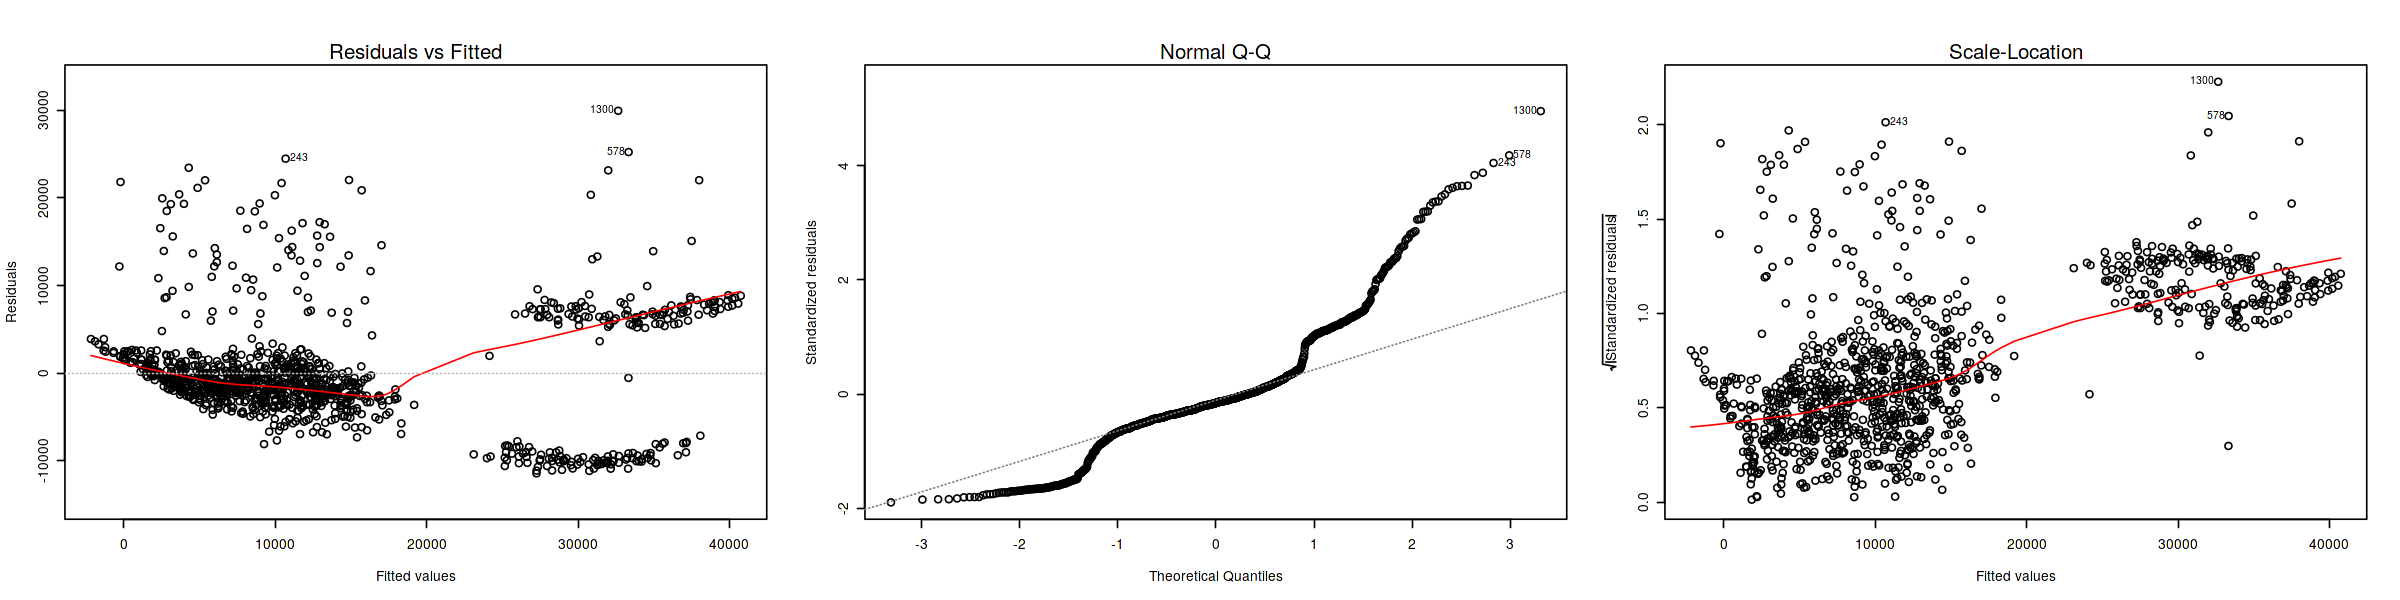

In [28]:
options(repr.plot.width=20, repr.plot.height=5)
par(mfrow=c(1,3))

plot(l_1, which=c(1,2,3))

The distribution of error terms looks normal seeing the boxplot, skewed to the left and with many outliers.  
At Residuals x Fitted plot, the non horizontal line may indicate a non-linear relationship.  
At Normal QQ plot, we see that the residuals are not exactly on the straight line, indicating that they are not normally distributed.  
At Scale-Location plot, the non straight line indicates heteroscedasticity.  

It is an over-dispersed data, that is, it has an increased number of outliers (i.e. the distribution has fatter tails than a normal distribution).

## Log Linear Regression
We want to correct the model inadequacies transforming the response variable to stabilize the variance.
We are going to use the log transformation presented in paragraph 4.

In [29]:
train$log_charges <- log(train$charges)
l_2 <- lm(log_charges ~ age + bmi + smoker + children + smoker + region, data = train)
summary(l_2)

l_2_pred <- predict(l_2, test)
radj <- summary(l_2)$adj.r.squared
rse <- sqrt(sum(residuals(l_2)^2) / l_2$df.residual ) 
rmse <- RMSE(l_2_pred, test$charges)
aic <- AIC(l_2)
l_2_reg <- cbind("Adjusted R sq"=radj, "RSE"=rse, "RMSE"=rmse, "AIC"=aic)


Call:
lm(formula = log_charges ~ age + bmi + smoker + children + smoker + 
    region, data = train)

Residuals:
     Min       1Q   Median       3Q      Max 
-1.12125 -0.19660 -0.04780  0.07315  2.12608 

Coefficients:
                  Estimate Std. Error t value             Pr(>|t|)    
(Intercept)      7.0127754  0.0815004  86.046 < 0.0000000000000002 ***
age              0.0343515  0.0009544  35.993 < 0.0000000000000002 ***
bmi              0.0135751  0.0023238   5.842        0.00000000686 ***
smokeryes        1.5494728  0.0329482  47.028 < 0.0000000000000002 ***
children         0.0967786  0.0111136   8.708 < 0.0000000000000002 ***
regionnorthwest -0.0730917  0.0383414  -1.906             0.056876 .  
regionsoutheast -0.1719384  0.0384527  -4.471        0.00000860497 ***
regionsouthwest -0.1464416  0.0386279  -3.791             0.000158 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.4376 on 1062 degrees of freedom
Multiple R-sq

In this model the significance level of $regionnorthwest$ has grown the other ones.
Adjusted R squared for the model, after transforming the response variable charges, is higher than that of linear regression.

### Model adequacy checking of Log Linear Regression

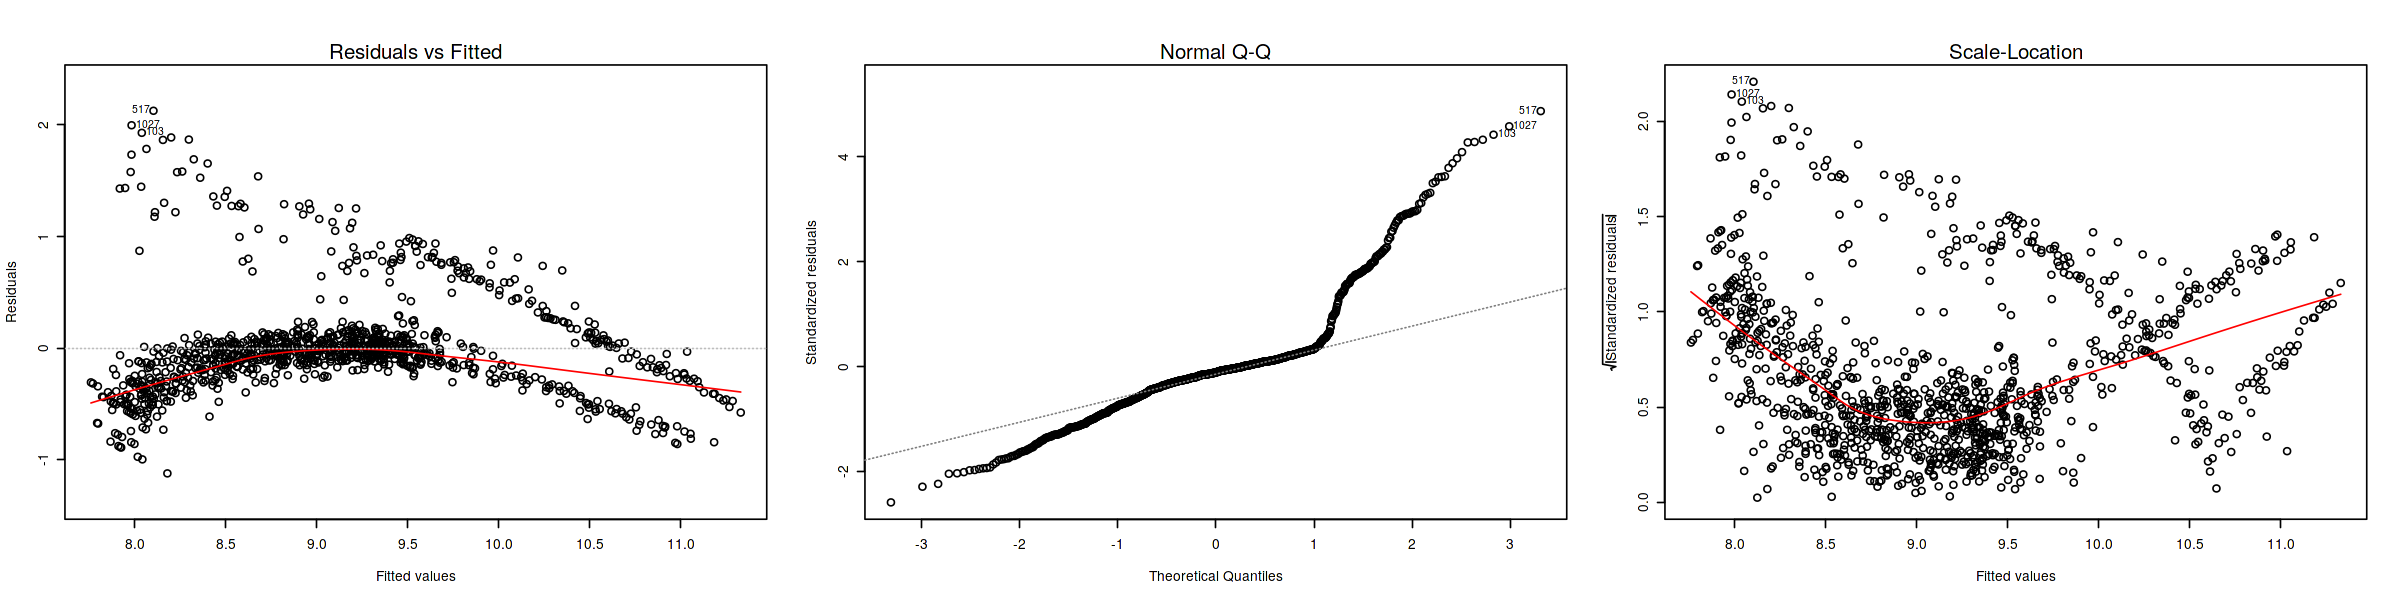

In [30]:
par(mfrow=c(1,3))
plot(l_2, which=c(1,2,3))

The distribution of error terms looks normal seeing the boxplot, skewed to the left and with many outliers.  
At Residuals x Fitted plot, the non horizontal line may indicate a non-linear relationship.  
At Normal QQ plot, we see that the residuals are not exactly on the straight line, indicating that they are not normally distributed.  
At Scale-Location plot, the non straight line indicates heteroscedasticity.  
It is an over-dispersed data, that is, it has an increased number of outliers (i.e. the distribution has fatter tails than a normal distribution).  
The increasing pattern is still observed but the evaluation has improved. Furthermore we could occur in overfitting.  


### Polynomial regression

In previous models we have used the features that, in most cases, have a low correlation. 
The residual plots exhibit parabolic trend, which provides a strong indication of non-linearity in the data.

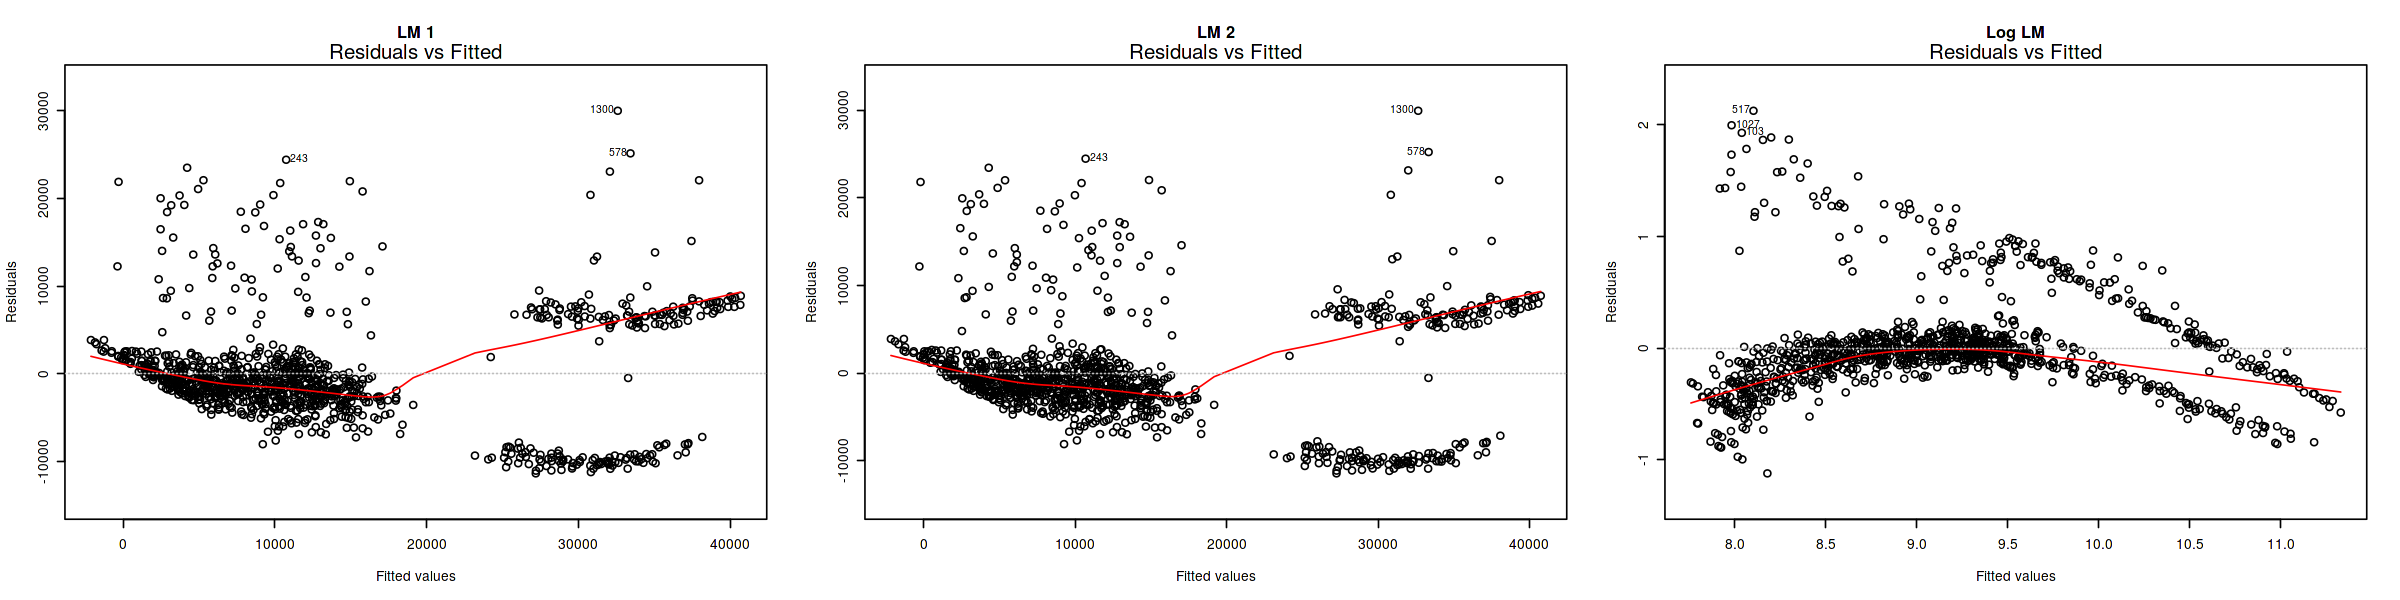

In [31]:
par(mfrow=c(1,3))

plot(l, c(1), main = 'LM 1')
plot(l_1, c(1), main = 'LM 2')
plot(l_2, c(1), main = 'Log LM')

We want to increase the correlation of the other features and we try to improve our model using the Polynomial regression. It is sensitive to outliers so the presence of one or two outliers can also badly affect the performance. The idea is to generate a new feature matrix consisting of all polynomial combinations of the features with degree 2.

We don’t want charges to be included in the process of generating the polynomial combinations, so we take out charges from train and test and save them as y_train and y_test, respectively.

In [32]:
y_train <- train$charges
y_test <- test$charges

From EDA we know that $sex$ has no correlation with $charges$. We can drop it. Also, since polynomial combinations don’t make sense to categorical features, we mutate $smoker$ and $region$ as numeric.

In [33]:
X_train <- train %>% 
  select(-c(charges, sex, log_charges)) %>% 
  mutate(smoker = as.numeric(smoker), region = as.numeric(region)) 
X_test <- test %>% 
  select(-c(charges, sex)) %>% 
  mutate(smoker = as.numeric(smoker), region = as.numeric(region))

We use the formula below to apply polynomial combinations.

In [34]:
formula <- as.formula(
  paste(' ~ .^2 + ', paste('poly(', colnames(X_train), ', 2, raw=TRUE)[, 2]', collapse = ' + '))
)

formula

~.^2 + poly(age, 2, raw = TRUE)[, 2] + poly(bmi, 2, raw = TRUE)[, 
    2] + poly(children, 2, raw = TRUE)[, 2] + poly(smoker, 2, 
    raw = TRUE)[, 2] + poly(region, 2, raw = TRUE)[, 2]

Then, insert y_train and y_test back to the new datasets.

In [35]:
train_poly <- as.data.frame(model.matrix(formula, data = X_train))
test_poly <- as.data.frame(model.matrix(formula, data = X_test))
train_poly$charges <- y_train
test_poly$charges <- y_test
colnames(train_poly)

[1] "(Intercept)"                        "age"                               
 [3] "bmi"                                "children"                          
 [5] "smoker"                             "region"                            
 [7] "poly(age, 2, raw = TRUE)[, 2]"      "poly(bmi, 2, raw = TRUE)[, 2]"     
 [9] "poly(children, 2, raw = TRUE)[, 2]" "poly(smoker, 2, raw = TRUE)[, 2]"  
[11] "poly(region, 2, raw = TRUE)[, 2]"   "age:bmi"                           
[13] "age:children"                       "age:smoker"                        
[15] "age:region"                         "bmi:children"                      
[17] "bmi:smoker"                         "bmi:region"                        
[19] "children:smoker"                    "children:region"                   
[21] "smoker:region"                      "charges"

We can see that our new datasets train_poly and test_poly now have 22 columns:
1. (Intercept) is a column consists of constant 1, this is the constant term in the polynomial.
2. age, bmi, children, smoker, region are the original features.
3. age², bmi², children², smoker², region² are the square of the original features.
4. age x bmi, age x children, age x smoker, age x region, bmi x children, bmi x smoker, children x smoker, children x region, smoker x region are nine interactions between pairs of five features.
5. charges is the target feature.

Now, we are ready to make the model. As usual, we start with all features and use the backward elimination using the function $step$.

In [36]:
temp <- lm(formula = charges ~ ., data = train_poly)
step(temp)

Start:  AIC=18127.63
charges ~ `(Intercept)` + age + bmi + children + smoker + region + 
    `poly(age, 2, raw = TRUE)[, 2]` + `poly(bmi, 2, raw = TRUE)[, 2]` + 
    `poly(children, 2, raw = TRUE)[, 2]` + `poly(smoker, 2, raw = TRUE)[, 2]` + 
    `poly(region, 2, raw = TRUE)[, 2]` + `age:bmi` + `age:children` + 
    `age:smoker` + `age:region` + `bmi:children` + `bmi:smoker` + 
    `bmi:region` + `children:smoker` + `children:region` + `smoker:region`


Step:  AIC=18127.63
charges ~ `(Intercept)` + age + bmi + children + smoker + region + 
    `poly(age, 2, raw = TRUE)[, 2]` + `poly(bmi, 2, raw = TRUE)[, 2]` + 
    `poly(children, 2, raw = TRUE)[, 2]` + `poly(region, 2, raw = TRUE)[, 2]` + 
    `age:bmi` + `age:children` + `age:smoker` + `age:region` + 
    `bmi:children` + `bmi:smoker` + `bmi:region` + `children:smoker` + 
    `children:region` + `smoker:region`


Step:  AIC=18127.63
charges ~ age + bmi + children + smoker + region + `poly(age, 2, raw = TRUE)[, 2]` + 
    `poly(bmi, 2


Call:
lm(formula = charges ~ age + bmi + children + smoker + `poly(age, 2, raw = TRUE)[, 2]` + 
    `poly(bmi, 2, raw = TRUE)[, 2]` + `age:region` + `bmi:smoker` + 
    `bmi:region`, data = train_poly)

Coefficients:
                    (Intercept)                              age  
                      14359.291                         -112.535  
                            bmi                         children  
                       -689.685                          643.828  
                         smoker  `poly(age, 2, raw = TRUE)[, 2]`  
                     -22562.223                            4.203  
`poly(bmi, 2, raw = TRUE)[, 2]`                     `age:region`  
                        -11.305                           18.792  
                   `bmi:smoker`                     `bmi:region`  
                       1512.345                          -39.363  


Save the best model as l_p, then predict. After that, calculate the metrics.

In [37]:
l_p <- lm(formula = charges ~ age + bmi + children + smoker + `poly(age, 2, raw = TRUE)[, 2]` + `poly(bmi, 2, raw = TRUE)[, 2]` + `age:region` +
          `bmi:smoker` + `bmi:region`, data = train_poly)
summary(l_p)

l_p_pred <- predict(l_p, test_poly)
radj <- summary(l_p)$adj.r.squared
rse <- sqrt(sum(residuals(l_p)^2) / l_p$df.residual ) 
rmse <- RMSE(l_p_pred, test$charges)
aic <- AIC(l_p)
l_p_reg <- cbind("Adjusted R sq"=radj, "RSE"=rse, "RMSE"=rmse, "AIC"=aic)


Call:
lm(formula = charges ~ age + bmi + children + smoker + `poly(age, 2, raw = TRUE)[, 2]` + 
    `poly(bmi, 2, raw = TRUE)[, 2]` + `age:region` + `bmi:smoker` + 
    `bmi:region`, data = train_poly)

Residuals:
     Min       1Q   Median       3Q      Max 
-11487.1  -1881.7  -1309.9   -369.8  30489.5 

Coefficients:
                                   Estimate  Std. Error t value
(Intercept)                      14359.2907   3796.2160   3.783
age                               -112.5352     74.6947  -1.507
bmi                               -689.6853    195.2247  -3.533
children                           643.8281    125.3795   5.135
smoker                          -22562.2234   1847.7310 -12.211
`poly(age, 2, raw = TRUE)[, 2]`      4.2026      0.8855   4.746
`poly(bmi, 2, raw = TRUE)[, 2]`    -11.3049      2.9126  -3.881
`age:region`                        18.7916      8.8472   2.124
`bmi:smoker`                      1512.3454     58.9156  25.670
`bmi:region`                       -39

We have nine features, all of which are significant on charges, except for $age$. From the coefficients, we know that a non-smoker zero years old who has no children and zero BMI will be charged \\$14,359 by health insurance (which we know this scenario is impossible). Also, since smoker has the biggest coefficient of all features, a unit change in smoker gives a bigger change in charges than a unit change in other features give, given all other features are fixed. In this case, given all other features are fixed, a non-smoker would have more charge than a smoker by -\\$22358.

### Model adequacy checking of Polynomial Regression

We need to make sure that there is a linear relationship between predictors and target variable. This can be done by visually looking at the correlation between each pair of predictor and target variable.

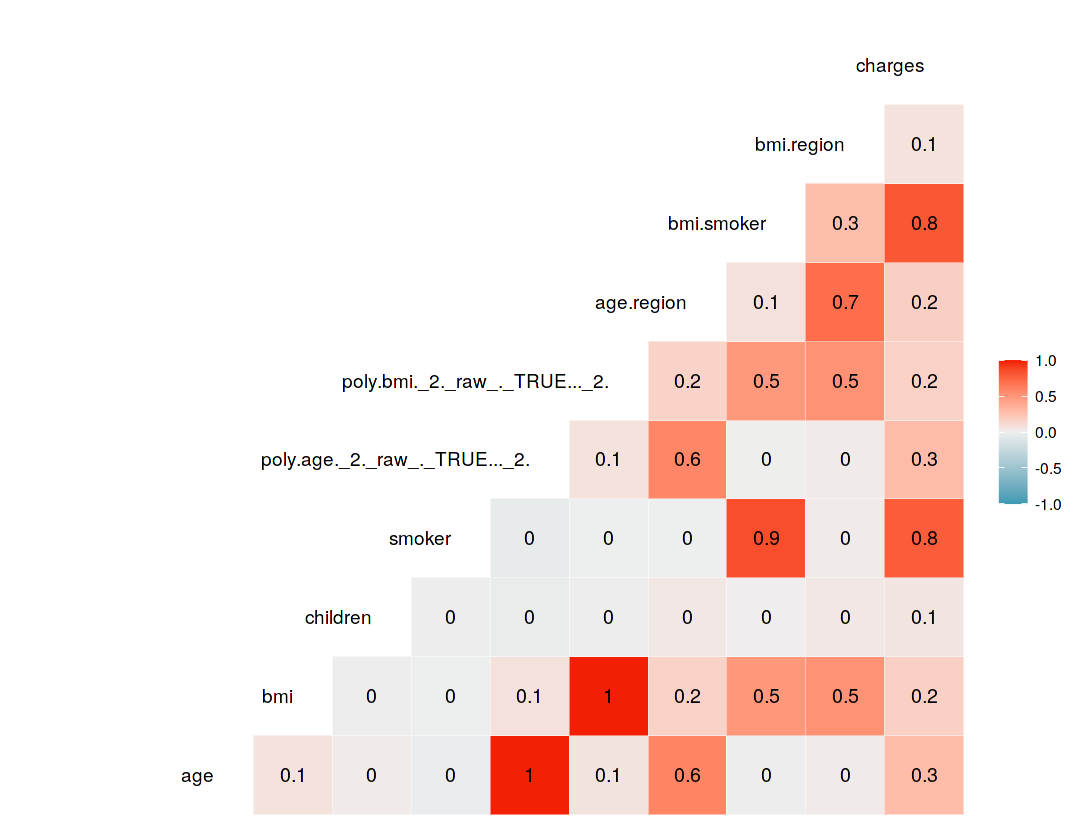

In [38]:
options(repr.plot.width=9, repr.plot.height=7)

cols <- c('age', 'bmi', 'children', 'smoker', 'poly(age, 2, raw = TRUE)[, 2]', 'poly(bmi, 2, raw = TRUE)[, 2]', 'age:region', 'bmi:smoker', 'bmi:region')
ggcorr(train_poly %>% select(c(all_of(cols), 'charges')), hjust = 1, layout.exp = 2, label = T)

Another way is to use hypothesis testing with Pearson’s product-moment correlation.
* $H_0$: the predictor does not correlate with $charge$
* $H_1$: the predictor correlates with $charge$

In [39]:
for (col in cols) {
  cor <- cor.test(train_poly[, col], train_poly$charges)
  print(round(cor$p.value, 4))
}

[1] 0
[1] 0
[1] 0.0718
[1] 0
[1] 0
[1] 0
[1] 0
[1] 0
[1] 0.02


Since the p-value for each predictor-target pair is below alpha (0.05) except for $children$, reject H0. We can safely say that the predictors correlate with target variable.

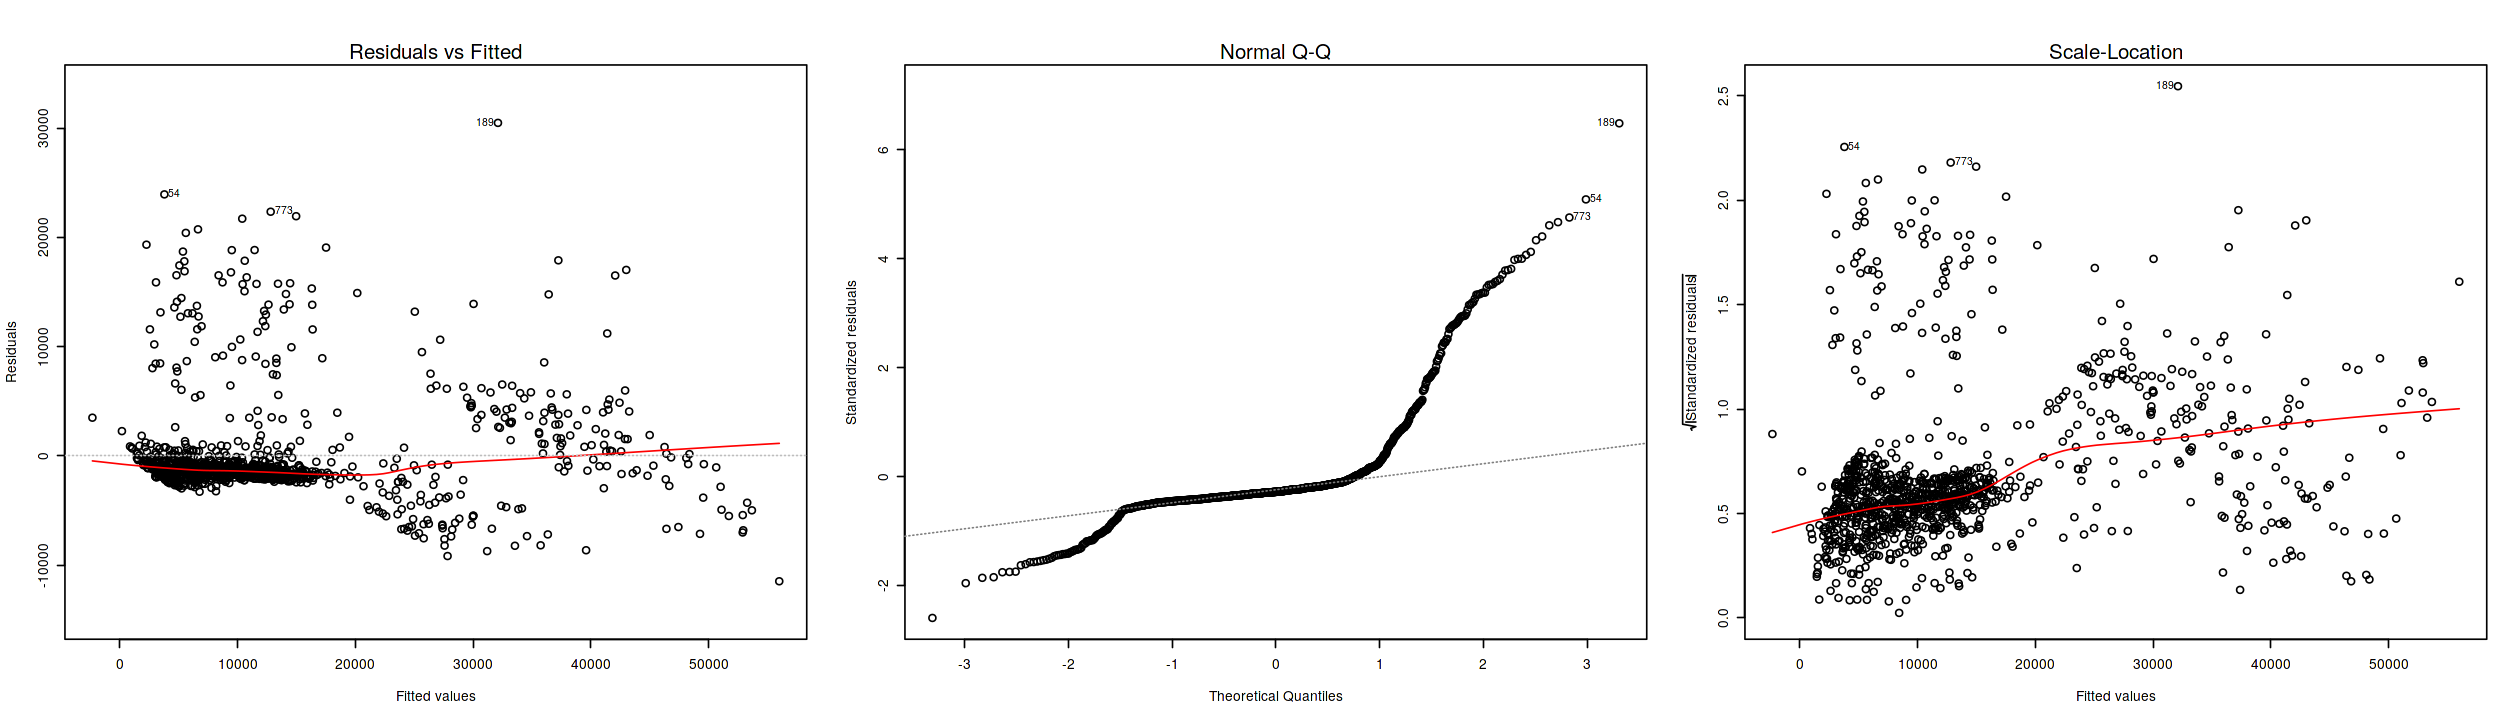

In [40]:
options(repr.plot.width=21, repr.plot.height=6)
par(mfrow=c(1,3))
plot(l_p, which=c(1,2,3))

The distribution of error terms looks normal seeing the boxplot, skewed to the left and with many outliers.  
At Normal QQ plot, we see that the residuals are not exactly on the straight line, indicating that they are not normally distributed.  
At Scale-Location plot, the non straight line indicates heteroscedasticity.  
It is an over-dispersed data, that is, it has an increased number of outliers (i.e. the distribution has fatter tails than a normal distribution).  


# Models Evaluation

Now we are going to compare the metrics between al the implemented models.

In [41]:
result <- rbind(l_reg, l_1_reg, l_2_reg, l_p_reg)
rownames(result) <- c("Linear Regression 1", "Linear Regression 2", "Log Linear Regression", "Polynomial Regression")
result

Adjusted R sq RSE          RMSE      AIC      
Linear Regression 1   0.7520835     6066.6897379  6062.979 21688.107
Linear Regression 2   0.7522864     6064.2064376  6063.061 21686.239
Log Linear Regression 0.7701225        0.4376392 17071.383  1278.087
Polynomial Regression 0.8499892     4719.1117562  5086.870 21151.546

#### Linear Regression 1 and Linear Regression 2
Adjusted R squared of these model is about 0.752, which means that 75.20% of the variation in charges could be explained by the independent variables we took in consideration. They might be good models, but we should also consider the other metrics used to compare their complexity with how well models fits the data.

#### Log Linear Regression
The metrics indicate that it is the best model, unless RMSE is used. The latter shows us that the model is very susceptible to overfitting.

#### Polynomial Regression
This model has a great variation of the charges indicated by the Adjusted R2. Compared to the first two models, polynomial regression should be more complex but fits the data very well. To conclude the RMSE indicates that the model shouldn't overfitting.

# Conclusion

The models we have built can be used for inference of how the different predictors influence the outcome but it is far from perfect. But some feature engineering such as polynomial regression plays an important role to improve the model. There is still presence of non-linearity and non-constant variance of errors. Moreover, the outliers points should be analyzed to find a better model. To obtain even more precision in its predictions, this insurance company should collect more data about its customers in order to explain the behavior of some individuals that we have noticed in the exploratory phase. 

We can be sure that smoking could affect your wallet.